# STATS 601: Microenvironment Microarrays
## Team Members: Aaron Abkemeier, Unique Subedi, Victor Verma, Yash Patel

Our analysis is split into the following sections:

- Staining set disparity
- Splotch analysis
- Treatment effect analysis
- Linear model analysis
- Dimensionality reduction
- Outlier detection

Each section is annotated with the corresponding code and figures in the sections below along with associated exposition.

## Code Setup
We start simply by loading in the data and organizing properties of subsequent interest.

In [5]:
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os
from scipy.ndimage.filters import gaussian_filter
import cv2
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

In [3]:
plates = {f"plate{fn[6:9]}": pd.read_csv(os.path.join("Data", fn), sep = '\t') for fn in os.listdir("Data")}
full_plates = sorted(list(plates.keys()))

num_stain_sets = 3
staining_set_size = 8
staining_sets = [full_plates[staining_set_size * stain_idx:staining_set_size * (stain_idx + 1)] for stain_idx in range(num_stain_sets)]

In [3]:
key_properties_to_cols = {
    "count": "Spot_PA_SpotCellCount",
    "nuclear_area": "Nuclei_CP_AreaShape_Area",
}

def populate_property_minmax(col_name):
    min_prop = np.min([np.min([plates[plate_name][col_name].min() for plate_name in staining_set]) for staining_set in staining_sets])
    max_prop = np.max([np.max([plates[plate_name][col_name].max() for plate_name in staining_set]) for staining_set in staining_sets])
    property_to_min_max[col_name] = (min_prop, max_prop)

property_to_min_max = {}
for key_property in key_properties_to_cols:
    populate_property_minmax(key_properties_to_cols[key_property])

In [4]:
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

# arghh, got these +1s and -1s floating around cause the data's 1 indexed...
def gen_well_viz_property(plate, well_idx, property):
    well = plate[plate["WellIndex"] == well_idx + 1]
    well_rows, well_cols = 35, 20
    well_heatmap = np.zeros((well_rows, well_cols))
    well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1] = well[property].values.reshape(well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1].shape)
    return well_heatmap

def viz_well(well_heatmap):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
    sns.heatmap(well_heatmap, ax=ax)
    plt.show()

def viz_plate_property(plate, property, viz_blur=False, fn=None):    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
    plt.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    well_heatmaps = [gen_well_viz_property(plate, well_idx, property) for well_idx in range(8)]
    min_prop, max_prop = property_to_min_max[property]
    well_rows, well_cols = 35, 20

    # for well_idx, well_heatmap in enumerate(well_heatmaps):
    for well_idx, ax in enumerate(axs.flat):
        well_row, well_col = well_idx // 4, well_idx % 4
        ax = axs[well_row, well_col]

        ax.axhline(y=0, color='w',linewidth=3)
        ax.axhline(y=well_rows, color='w',linewidth=3)
        ax.axvline(x=0, color='w',linewidth=3)
        ax.axvline(x=well_cols, color='w',linewidth=3)

        viz_heatmap = well_heatmaps[well_idx]
        if viz_blur:
            viz_heatmap = gaussian_filter(viz_heatmap, sigma=1)

        sns.heatmap(
            viz_heatmap, ax=ax, vmin=min_prop, vmax=max_prop, linewidths=1, 
            linecolor='black', xticklabels=False, yticklabels=False, 
            cbar=(well_idx == 0), cbar_ax=None if well_idx else cbar_ax
        )
    if fn is not None:
        plt.savefig(fn)
    plt.show()

## Staining Set Disparity
### Unnormalized Comparison
We start with basic visualization of the data in the well structure it was collected in. Partitions are drawn for the wells within a given plate. Some observations are revealed through that and visualizing distributions. One is that supposedly equivalent plates across staining sets are *not* distributed evenly in terms of absolute cell counts. We repeat this analysis for nuclear area to demonstrate that such a distributional asymmetry is not an isolated artifact of the cell count. It is worth noting that this analysis reveals not only that the *means* differ across the staining sets, but so too do the distributional spreads. The general shapes, however, are roughly comparable, which is made more apparent in our subsequent analysis of the corresponding normalized quantities.

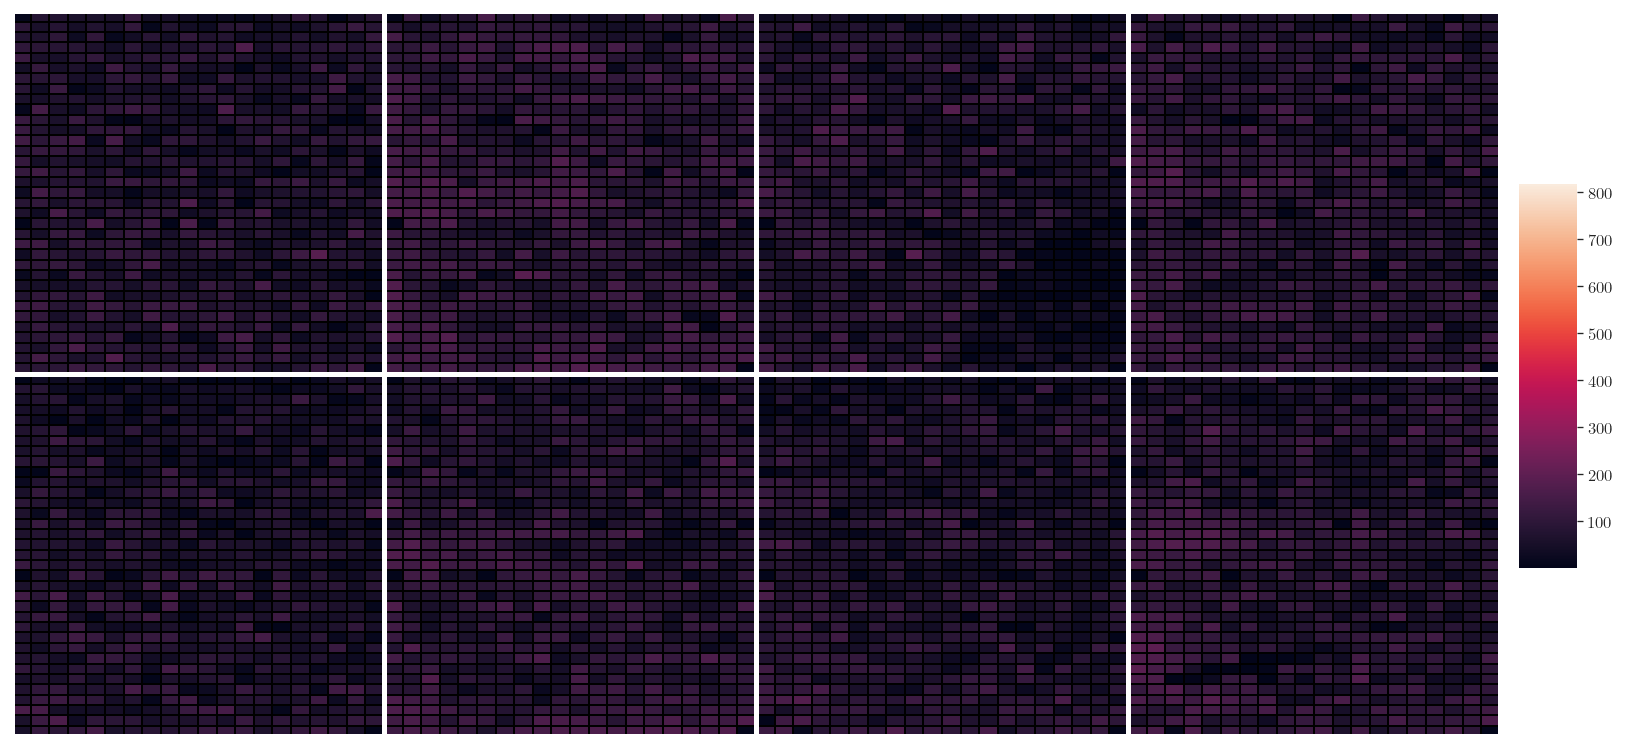

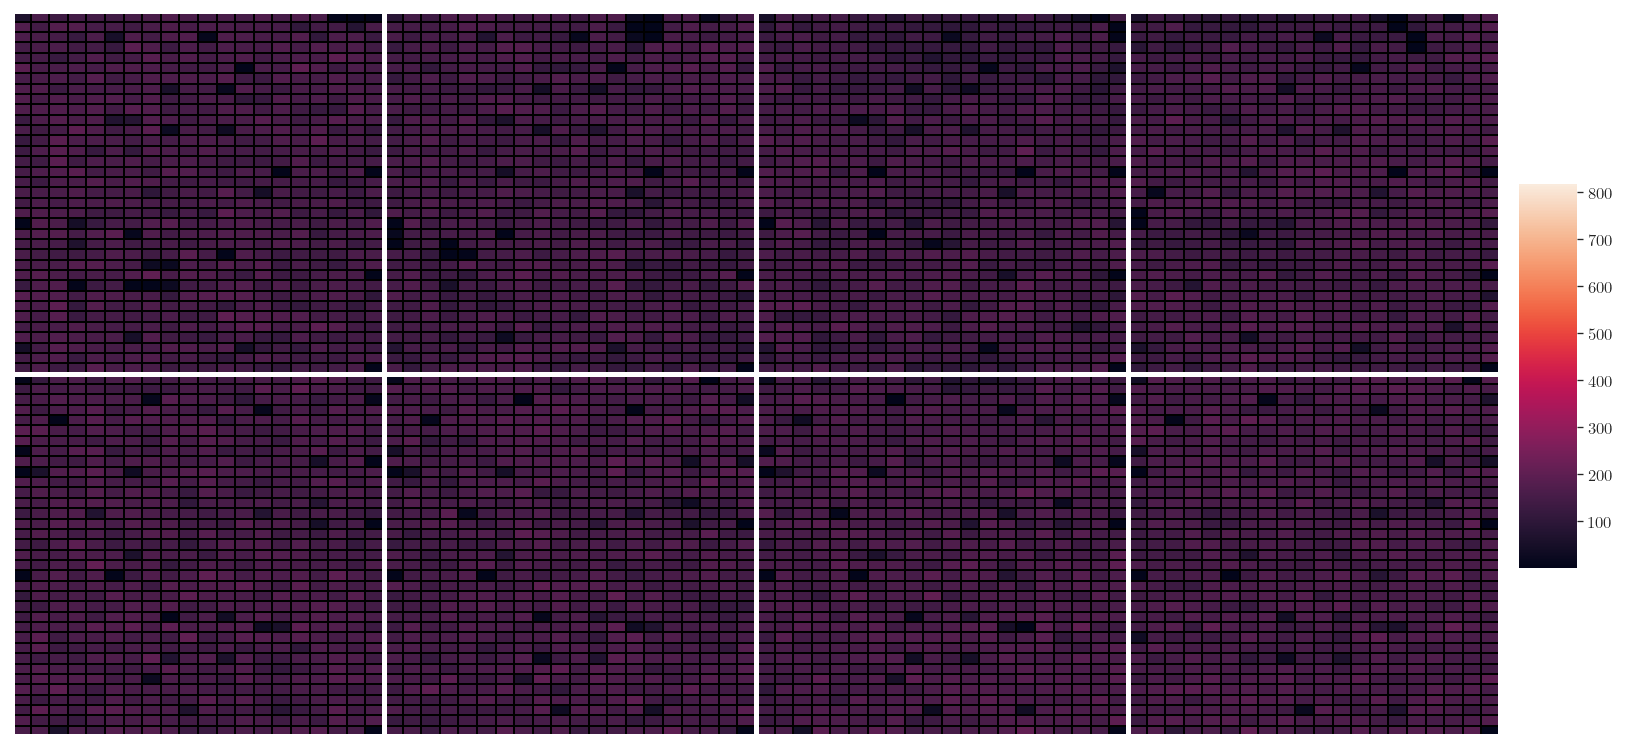

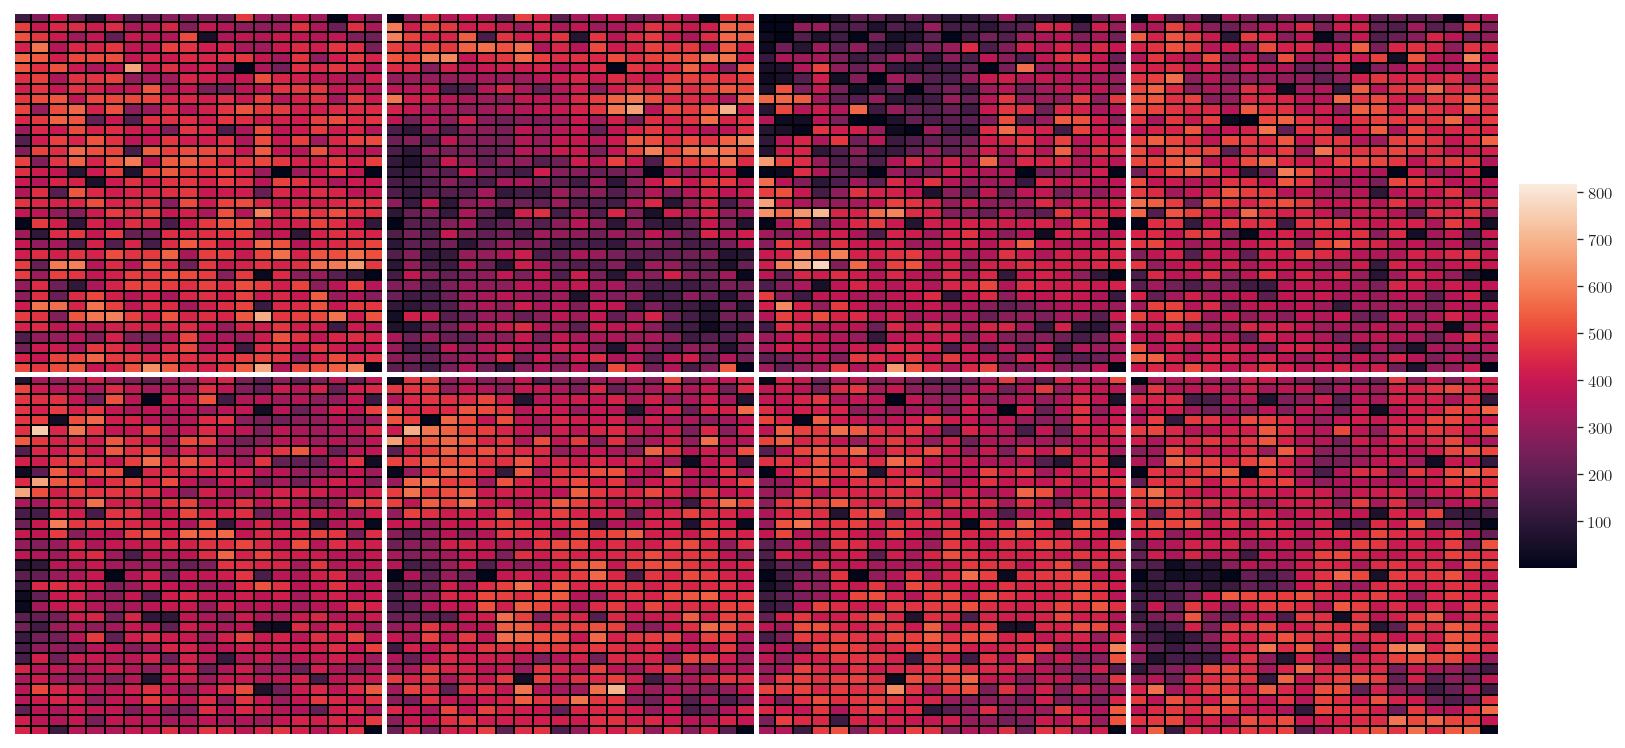

In [5]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, key_properties_to_cols["count"], fn=f"images/unnormed_count_set{staining_set_idx}.png")

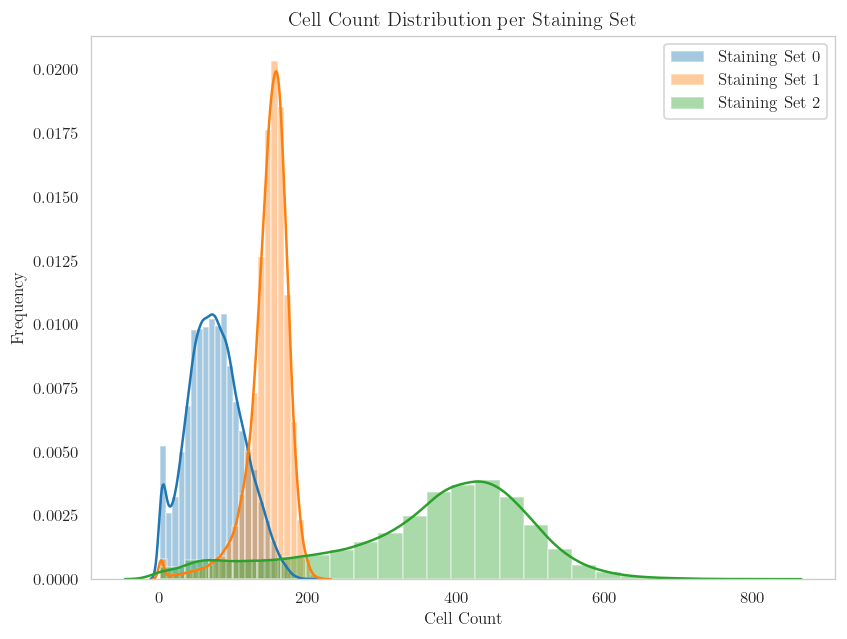

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, bins=25, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Cell \ Count \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Cell \ Count}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.savefig("images/unnormed_count_dist.png", bbox_inches='tight')

As mentioned above, repeating this analysis for the nuclear area reveals a similar disparity across staining sets:

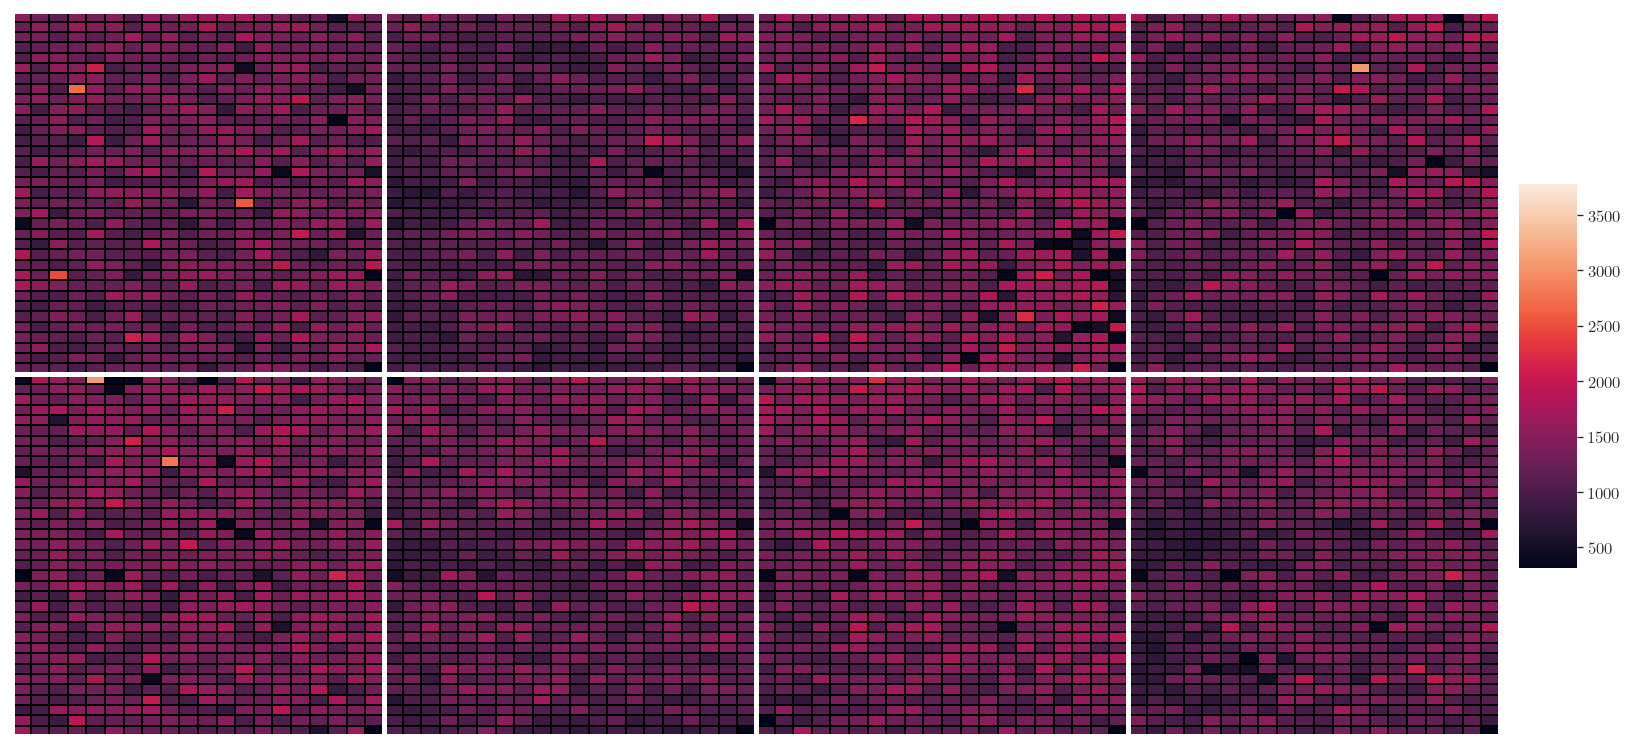

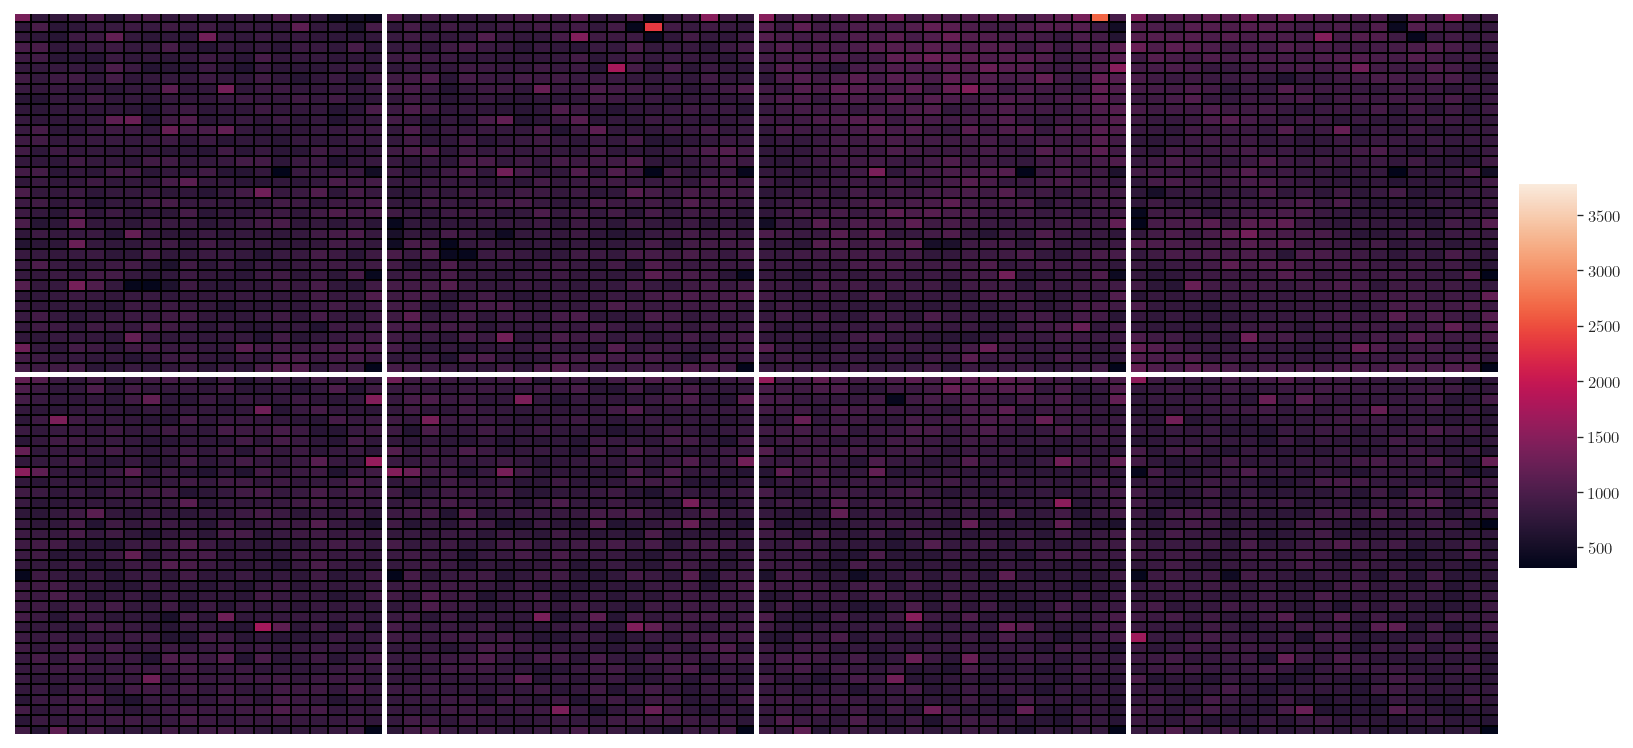

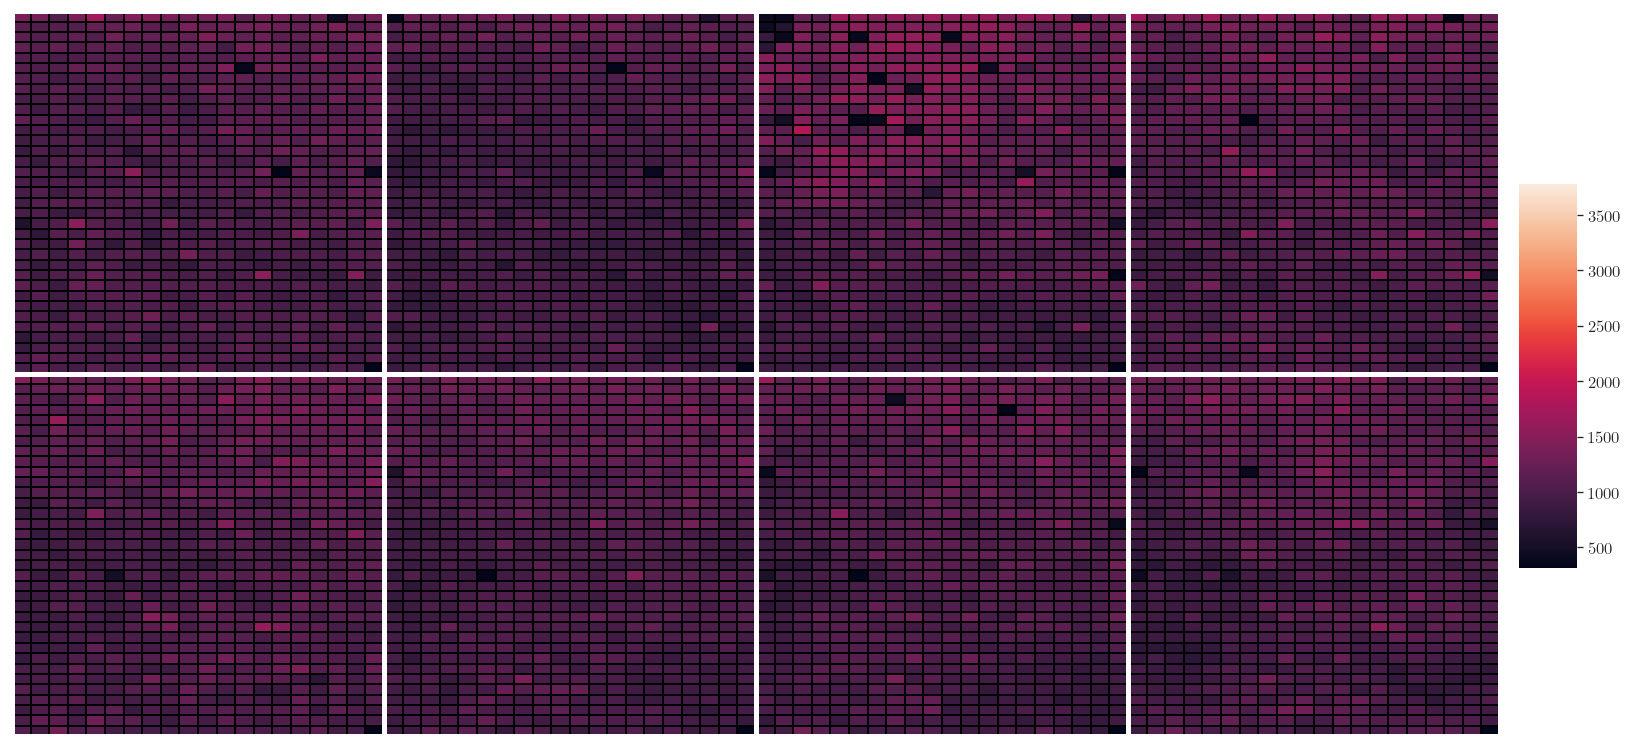

In [7]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, key_properties_to_cols["nuclear_area"], fn=f"images/unnormed_nuclear_area_set{staining_set_idx}.png")

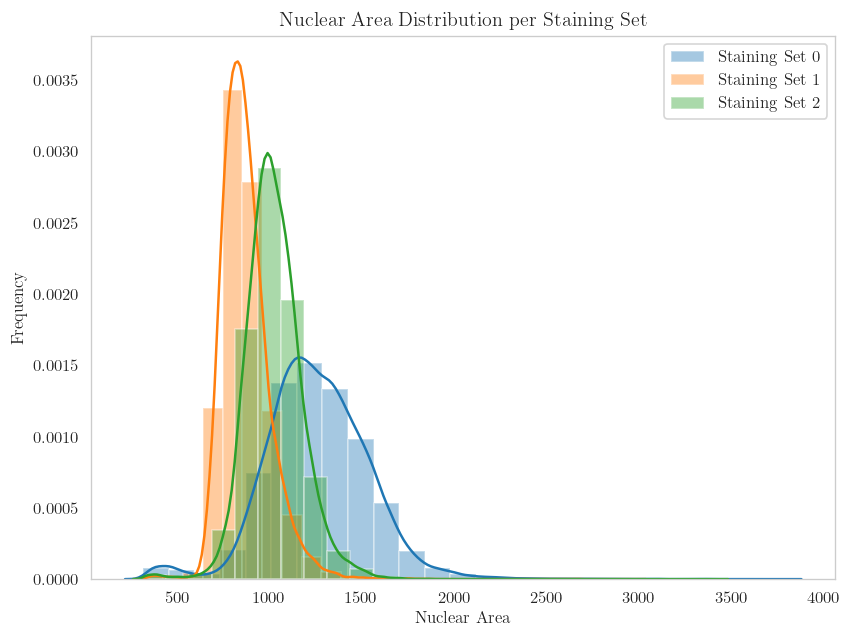

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name][key_properties_to_cols["nuclear_area"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, bins=25, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Nuclear \ Area \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Nuclear \ Area}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.savefig("images/unnormed_nuclear_area_dist.png", bbox_inches='tight')

### Normalized Comparison
We observe that normalizing the data improves alignment of the distributions, both from visual inspection of the data and looking at the corresponding distribution plots. The normalization factors $\overline{x}, \sigma_x$ are computed *per* staining set. That is, for each staining set, the mean and standard deviation were computed and shared for normalization across all wells in that staining set:

$$ \widehat{x} \gets \frac{x - \overline{x}}{\sigma_x} $$ 

In [9]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    full_mean = np.mean(full_counts)
    full_std = np.std(full_counts)
    
    for plate_name in staining_set:
        plates[plate_name]["std_count"] = (plates[plate_name][key_properties_to_cols["count"]] - full_mean) / full_std
populate_property_minmax("std_count")

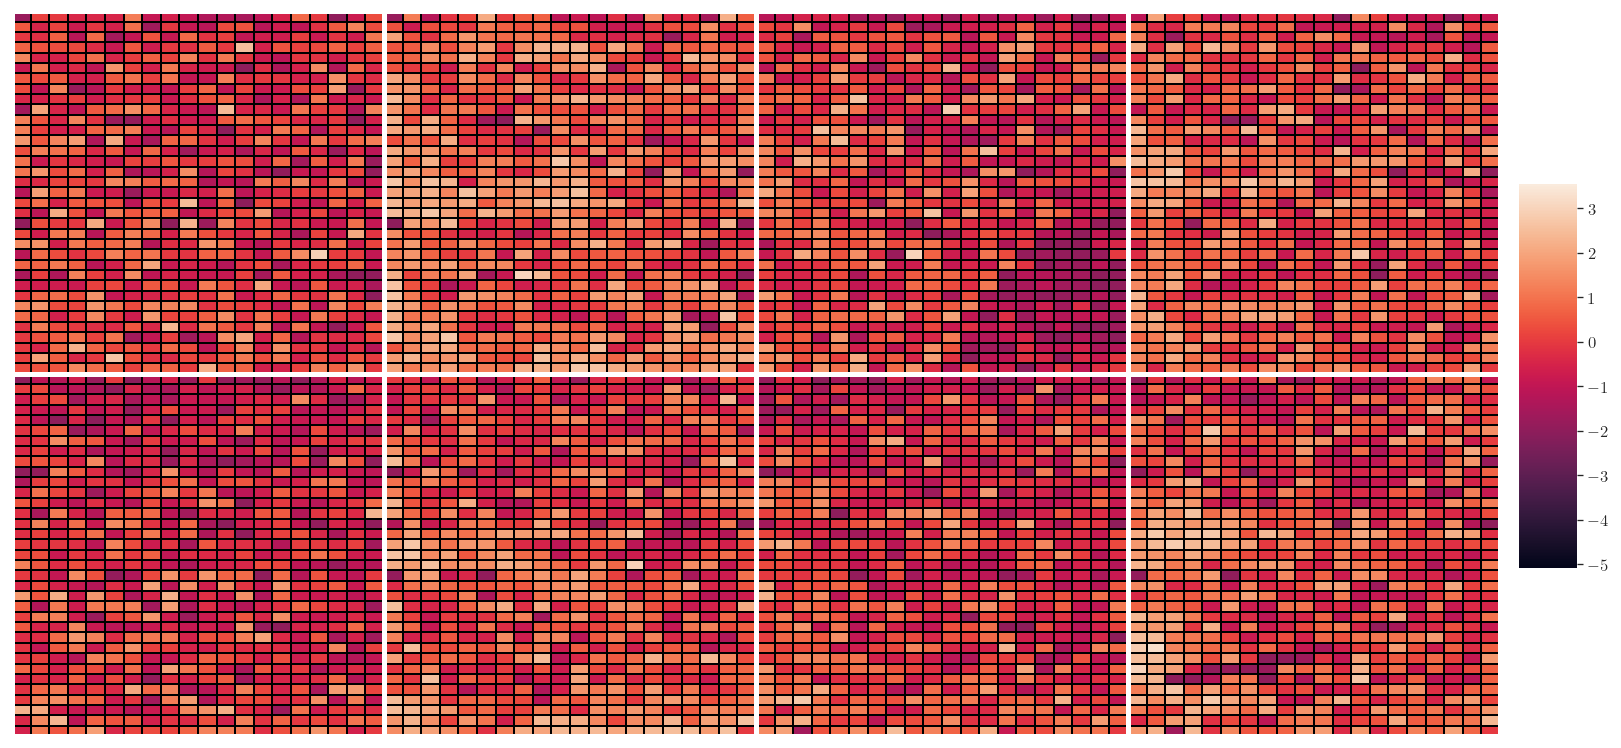

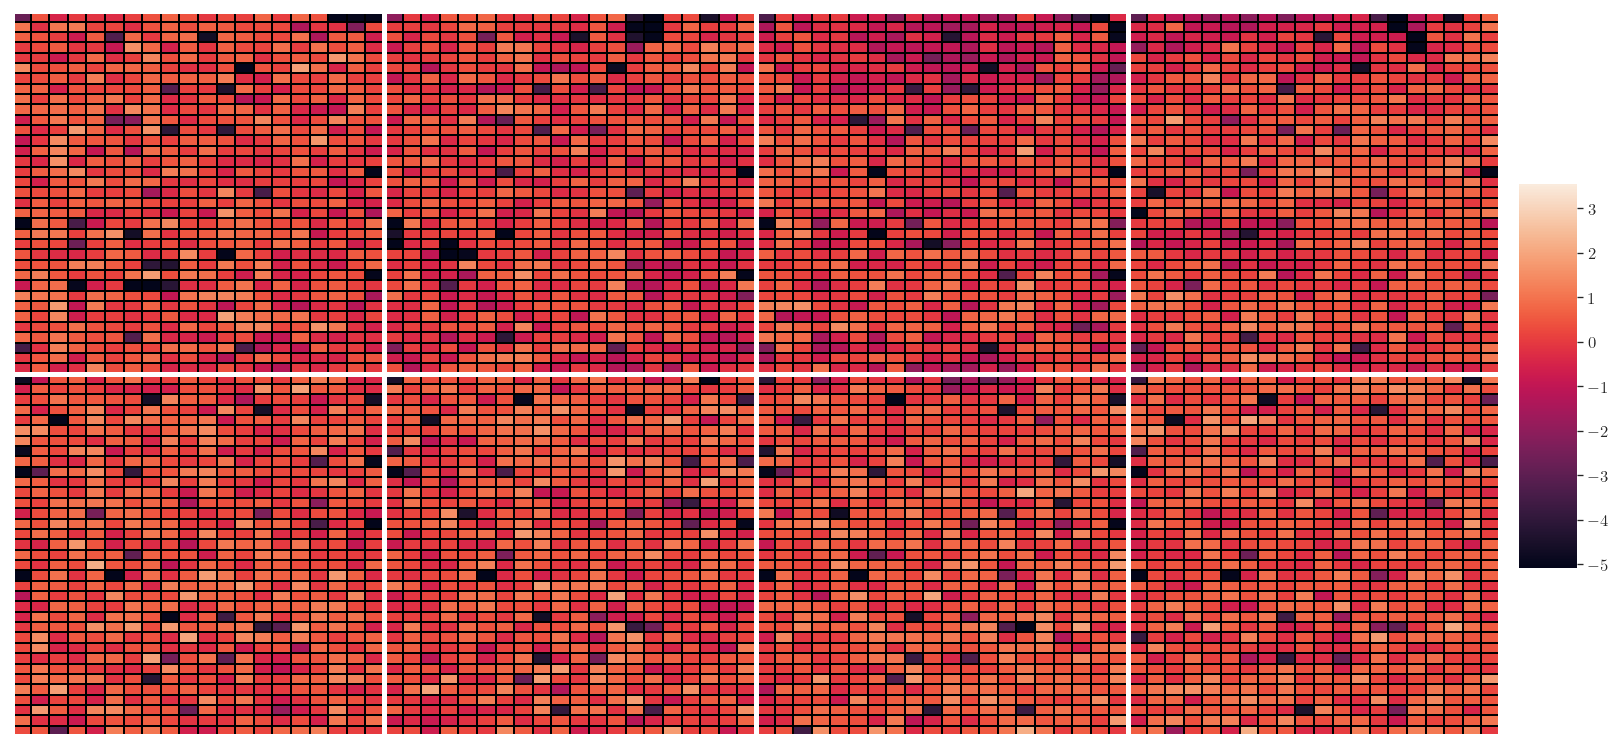

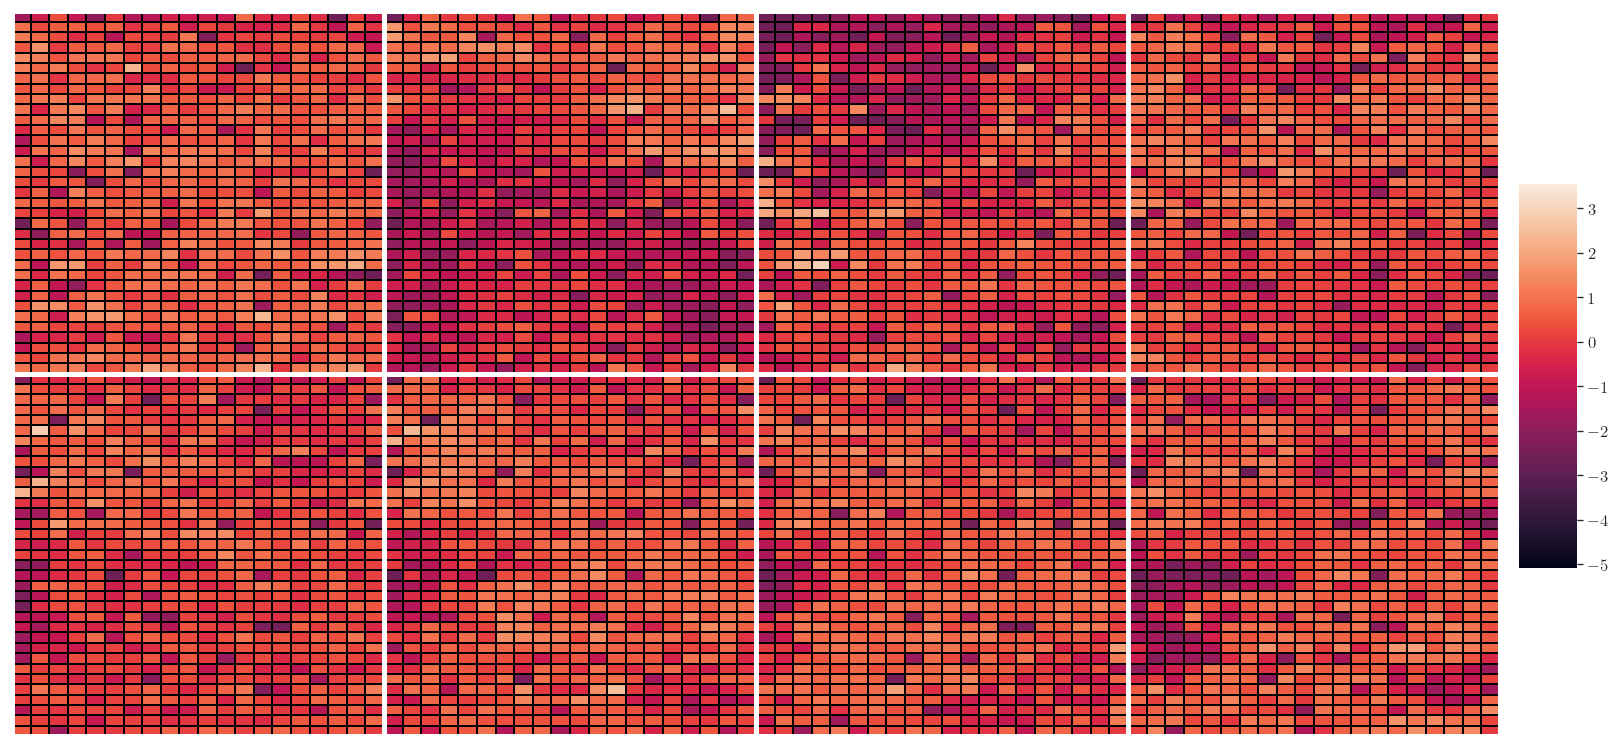

In [10]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, "std_count", fn=f"images/normed_count_set{staining_set_idx}.png")

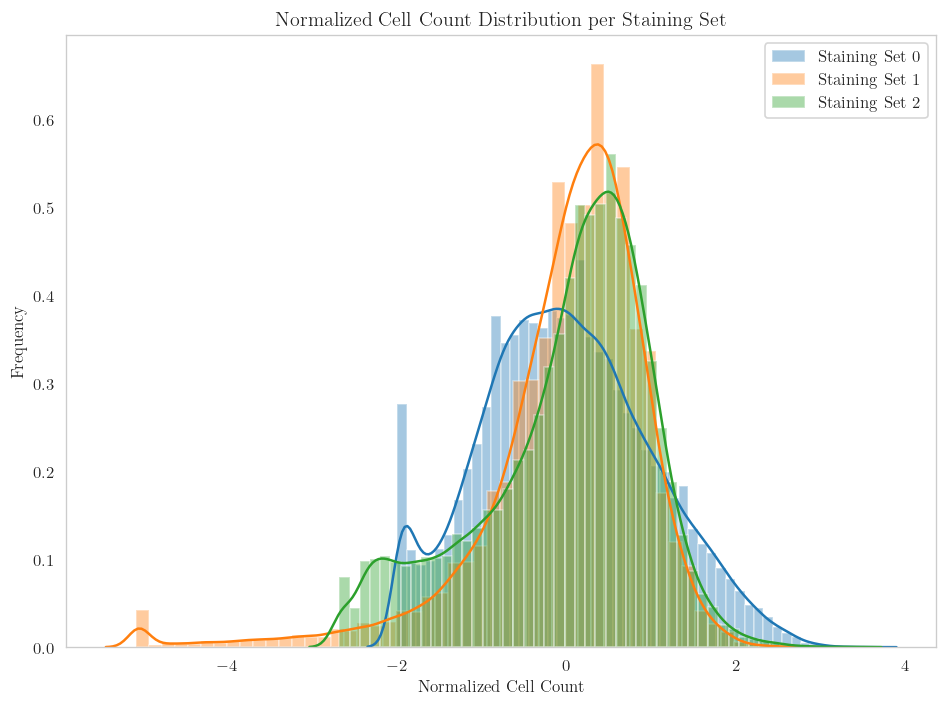

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name]["std_count"] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Normalized \ Cell \ Count \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Normalized \ Cell \ Count}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.tight_layout()
plt.savefig("images/normed_count_dist.png", bbox_inches='tight')

Once again repeating this normalization for the nuclear area, we see a similar result emerge.

In [12]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["nuclear_area"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    full_mean = np.mean(full_counts)
    full_std = np.std(full_counts)
    
    for plate_name in staining_set:
        plates[plate_name]["std_nuclear_area"] = (plates[plate_name][key_properties_to_cols["nuclear_area"]] - full_mean) / full_std
populate_property_minmax("std_nuclear_area")

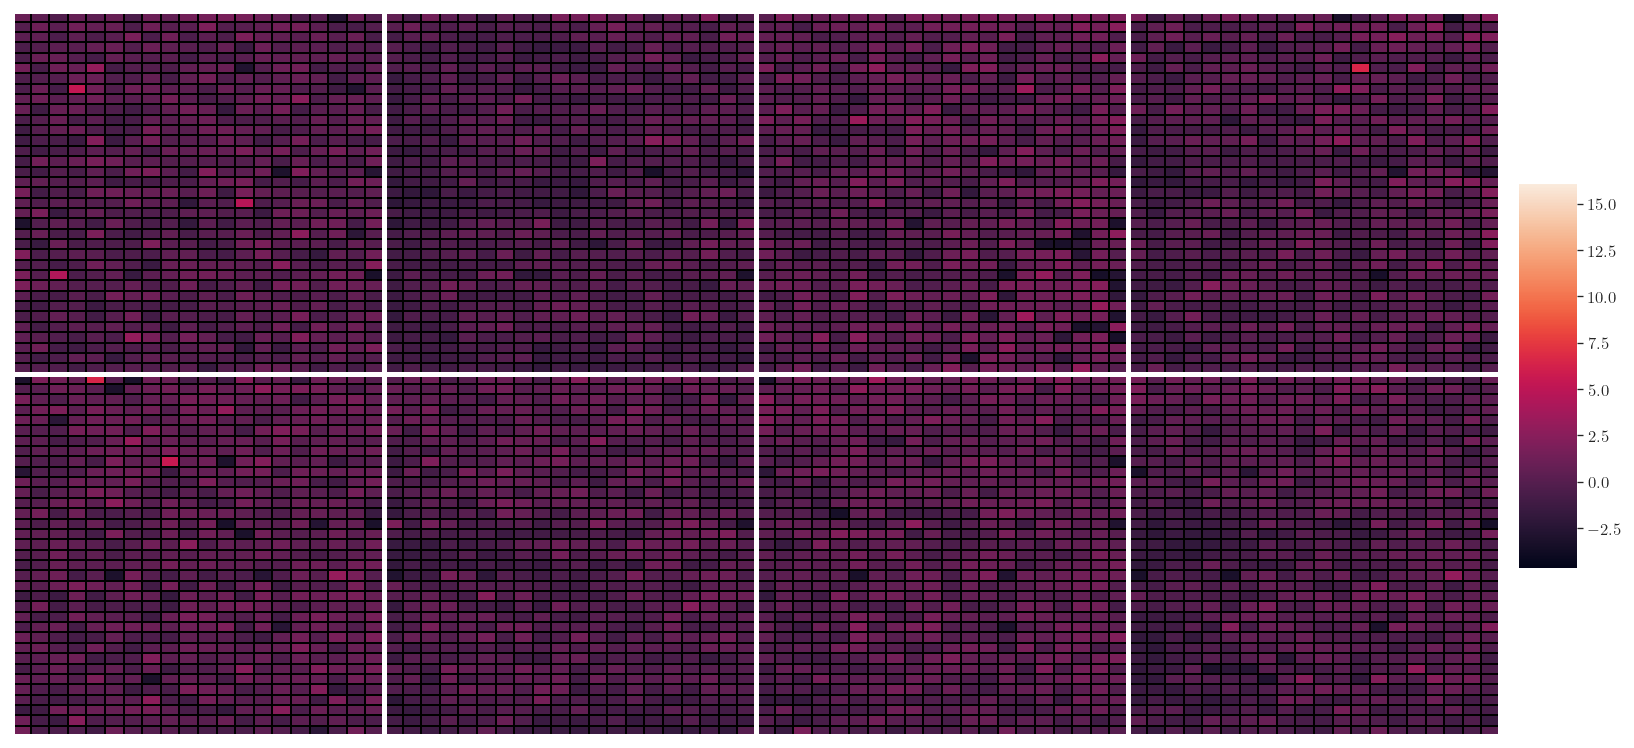

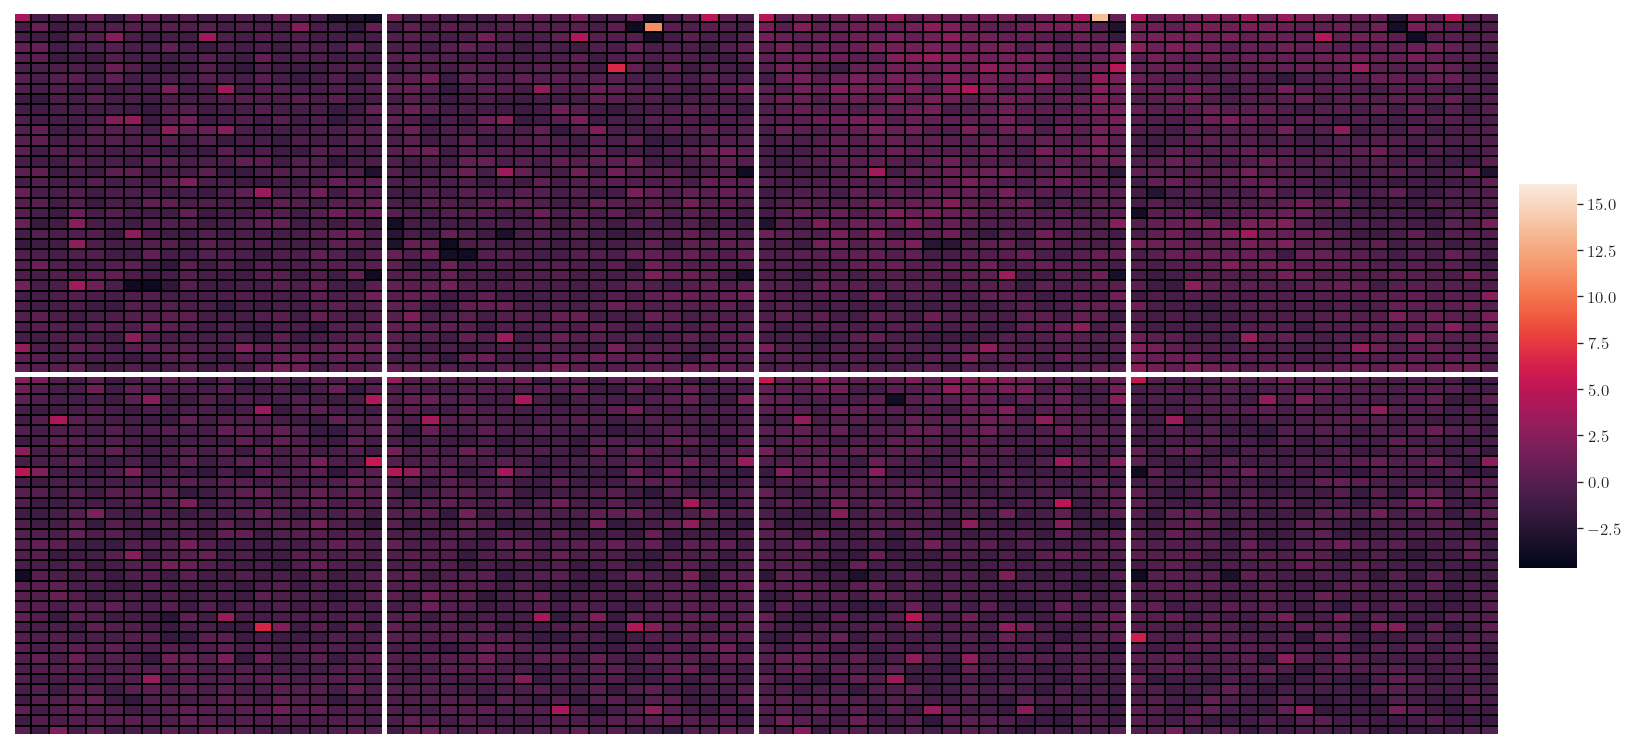

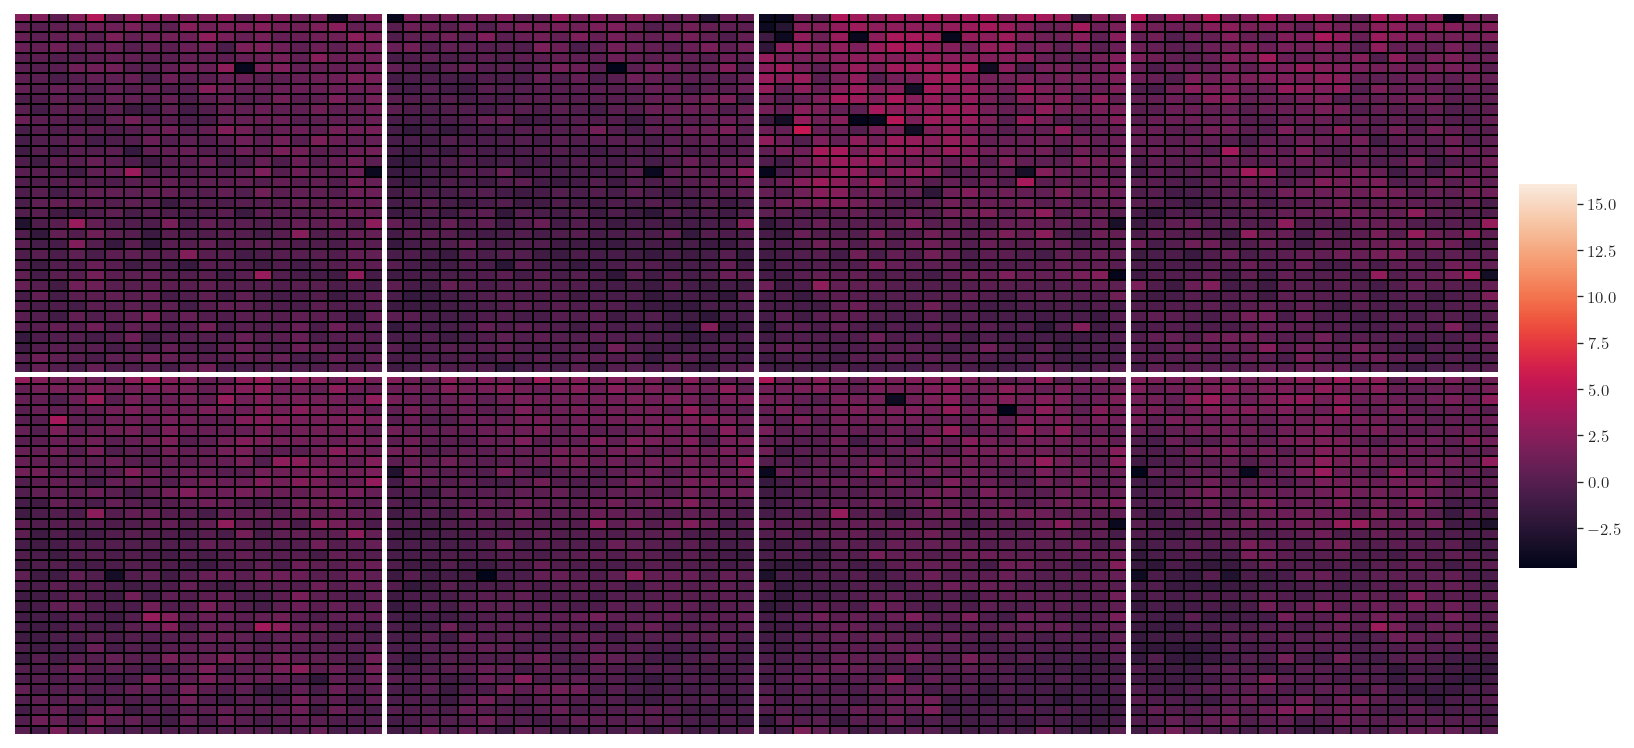

In [13]:
for staining_set_idx, staining_set in enumerate(staining_sets):
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, "std_nuclear_area", fn=f"images/normed_nuclear_area_set{staining_set_idx}.png")

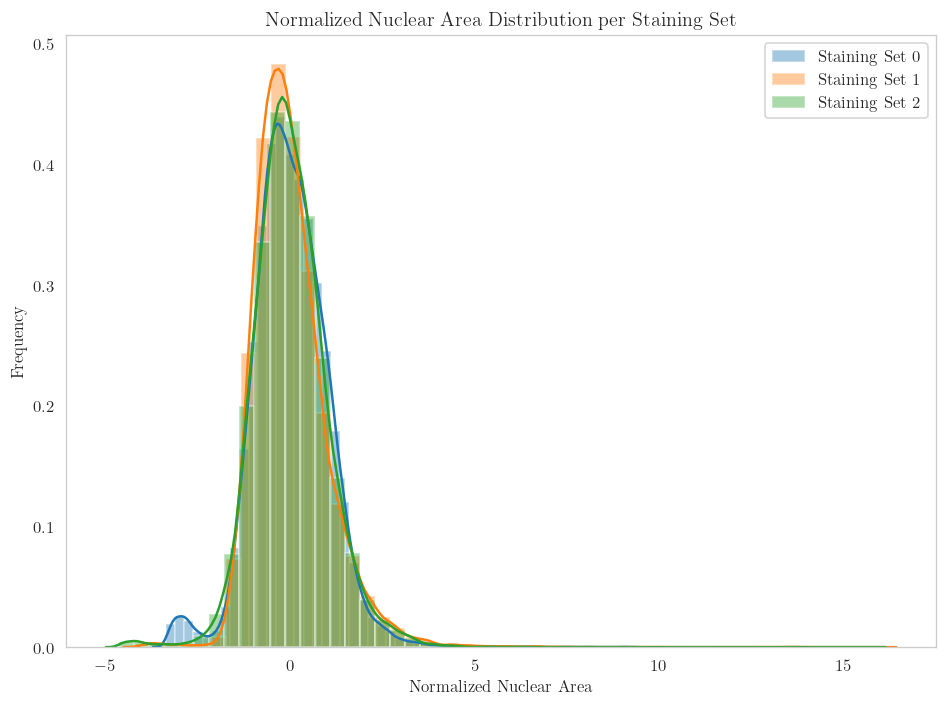

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

for staining_set_idx, staining_set in enumerate(staining_sets):
    staining_set_counts = [plates[plate_name]["std_nuclear_area"] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    sns.distplot(full_counts, label=r"$\mathrm{Staining \ Set \ " + str(staining_set_idx) + r"}$")

plt.title(r"$\mathrm{Normalized \ Nuclear \ Area \ Distribution \ per \ Staining \ Set}$")
plt.xlabel(r"$\mathrm{Normalized \ Nuclear \ Area}$")
plt.ylabel(r"$\mathrm{Frequency}$")

plt.legend()
plt.tight_layout()
plt.savefig("images/normed_nuclear_area_dist.png", bbox_inches='tight')

### Staining Set Disparity Takeaway
Observing the distributional disparities between these staining sets, we recommend analysis be conducted *separately* per staining set. If, however, it is of interest to combine staining sets for shared features, such as the cell count and nuclear area described above, we recommend the you normalize the data features prior to combining them, which serves to align the corresponding empirical distributions well.

## Splotch Analysis
Similarly, visualizing the plates across the staining sets reveals strong spatial structure, once again unexpected coming into the analysis. Given the randomization of ECMP locations per plate, we would not expect any spatial coherence of the data, with the most likely source being an external factor introduced through experimental error. To visualize this, we use the properties normalized *per well* and run a connected components analysis on regions with values $< -1.0$ in this normalized space. "Connected components" here refers to finding contiguous pixels (defined to be pixels that are either horizontally, vertically, or diagonally connected) and only keeping those components of sufficiently large area (taken to be 5 here). This allows us to find *regions* of the image that have lower cell count/area rather than individual spots, which may have lower cell count/area for completely valid experimental reasons (i.e. due to interactions with the ligand/ECMP). That is, we wish to just inspect the regions we believe to be due to experimental error.

We begin by illustrating this phenomenon on the cell counts. Note that we show a subset of plates for succinctness, but this pattern is evident across other plates than simply those visualized here.

In [20]:
def connected_components_analysis(property_name):
    heatmap_mask = None

    for staining_set_idx, staining_set in enumerate(staining_sets):
        for plate_idx, plate_name in enumerate(staining_set):
            do_viz = staining_set_idx == 2 and plate_idx in [5,6,7]
            if do_viz:
                fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
                plt.subplots_adjust(wspace=0, hspace=0)
            
            for well_idx in range(8):
                plate = plates[plate_name]
                # well_std_count = gen_well_viz_property(plate, well_idx, [key_properties_to_cols["count"]])
                well_count = gen_well_viz_property(plate, well_idx, [key_properties_to_cols[property_name]])
                well_std_count = (well_count - np.mean(well_count)) / np.std(well_count)
                thresh = (well_std_count < -1.5).astype(np.int8)
                output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
                (numLabels, labels, stats, centroids) = output
                mask = np.zeros(thresh.shape, dtype="uint8")

                # loop over the number of unique connected component labels, skipping
                # over the first label (label zero is the background)
                for i in range(1, numLabels):
                    x = stats[i, cv2.CC_STAT_LEFT]
                    y = stats[i, cv2.CC_STAT_TOP]
                    w = stats[i, cv2.CC_STAT_WIDTH]
                    h = stats[i, cv2.CC_STAT_HEIGHT]
                    area = stats[i, cv2.CC_STAT_AREA]

                    if area > 5:
                        componentMask = (labels == i).astype("uint8") * 255
                        mask = cv2.bitwise_or(mask, componentMask)

                if heatmap_mask is None:
                    heatmap_mask = copy.deepcopy(mask)
                else:
                    heatmap_mask += (mask // 255)

                if do_viz:
                    well_rows, well_cols = 35, 20
                    ax = axs[well_idx // 4, well_idx % 4]
                    ax.axhline(y=0, color='w',linewidth=3)
                    ax.axhline(y=well_rows, color='w',linewidth=3)
                    ax.axvline(x=0, color='w',linewidth=3)
                    ax.axvline(x=well_cols, color='w',linewidth=3)
                    
                    sns.heatmap(
                        mask, ax=ax, linewidths=1, 
                        cbar=False, cbar_ax=None, vmin=0, vmax=1,
                        linecolor='black', xticklabels=False, yticklabels=False, 
                    )
    return heatmap_mask

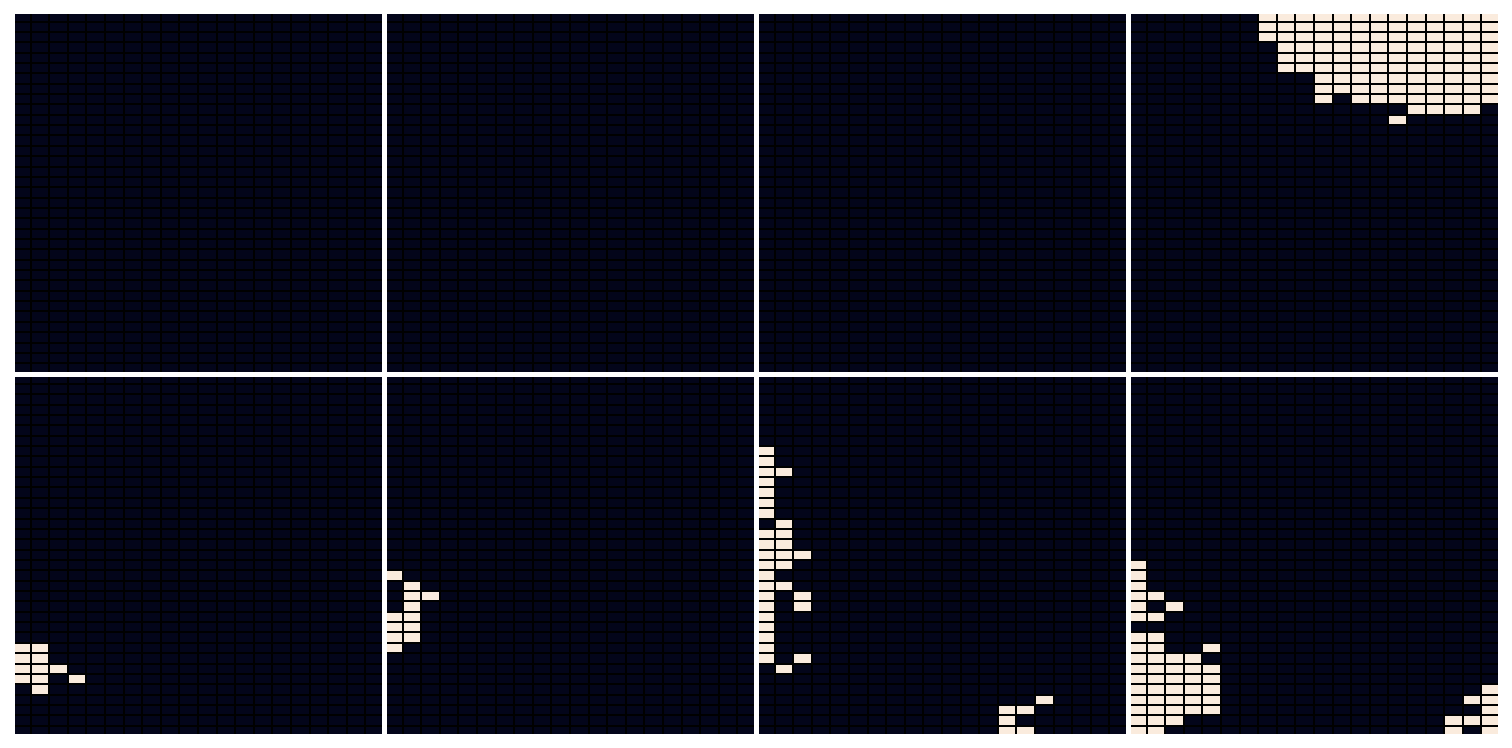

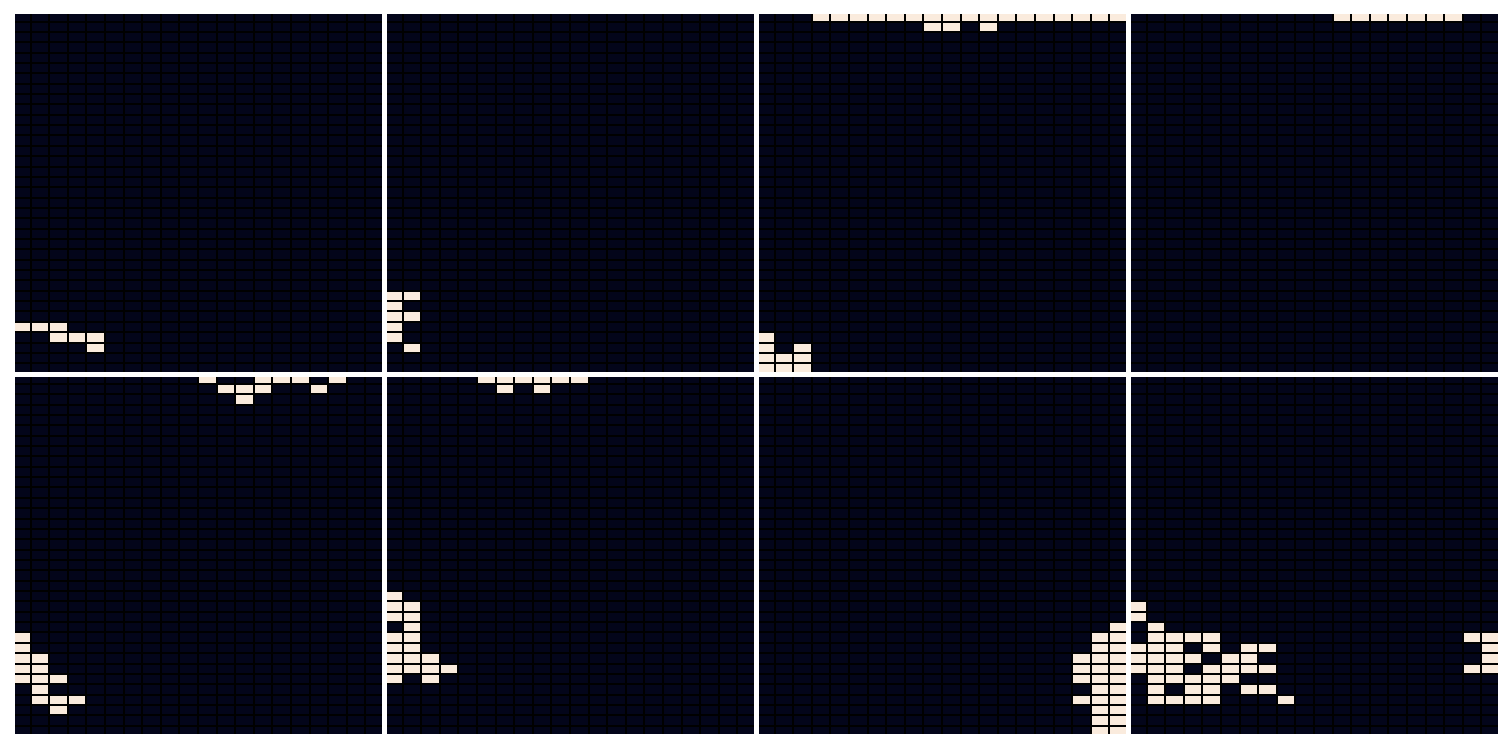

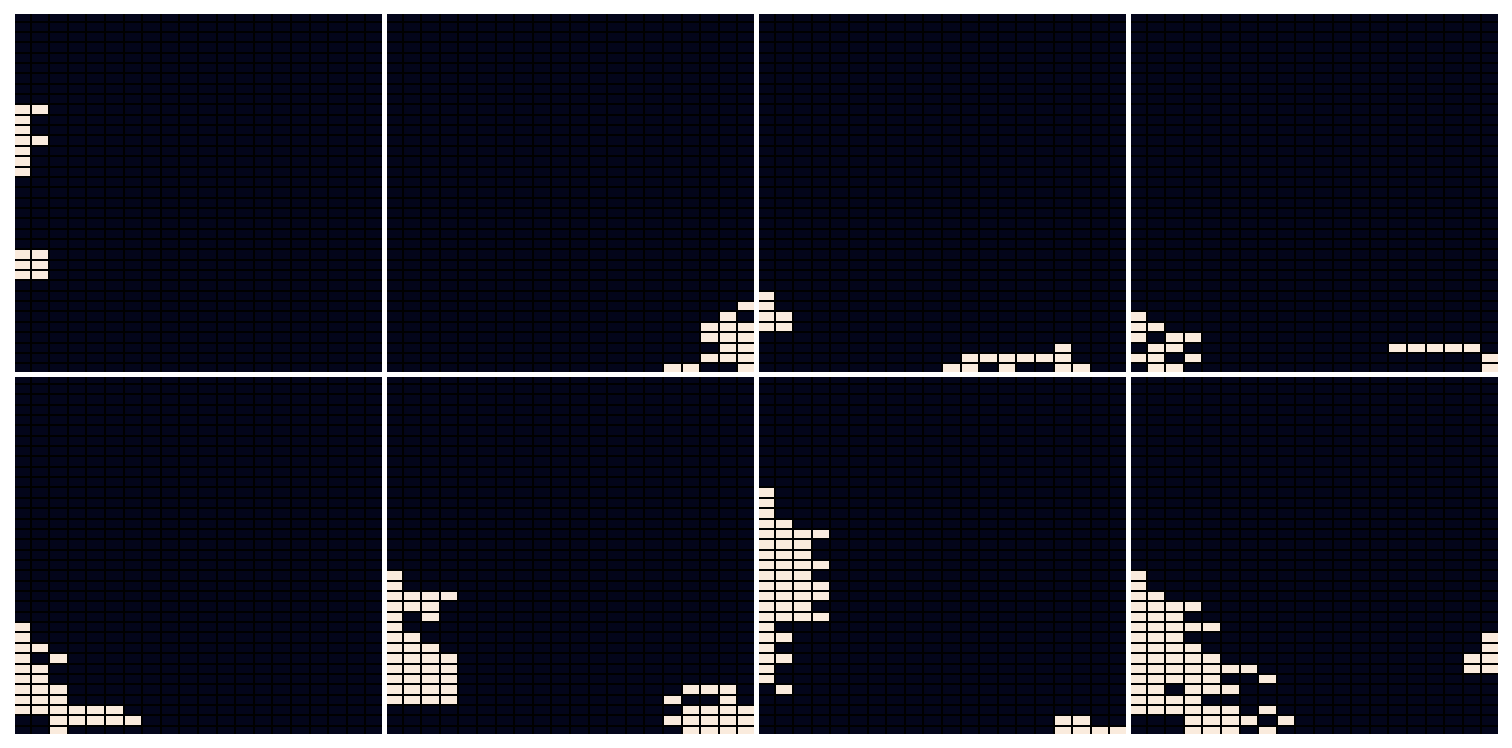

In [21]:
count_mask = connected_components_analysis("count")

If we layer these masks atop one another, we see an interesting spatial pattern: these regions of low cell count appear to concentrate most heavily in regions around the edges and corners of the wells.

<Figure size 432x288 with 0 Axes>

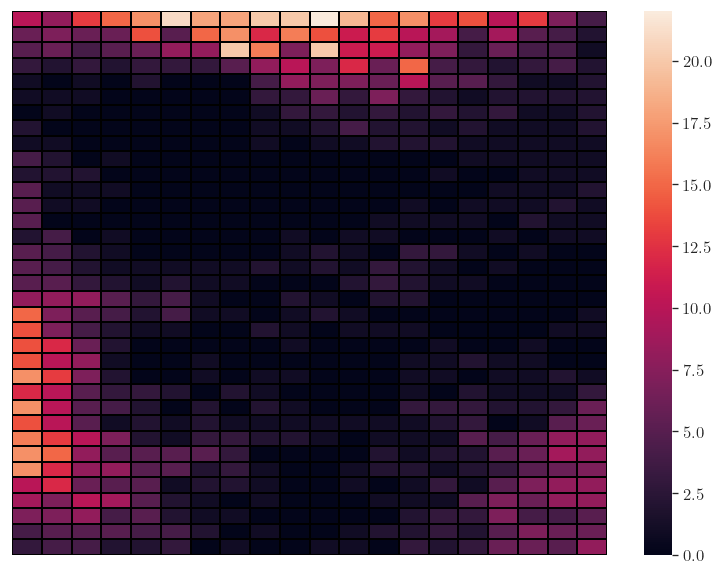

In [17]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
sns.heatmap(
    count_mask, ax=ax, linewidths=1, 
    linecolor='black', xticklabels=False, yticklabels=False, 
)
plt.show()

We repeat this analysis on the nuclear area to demonstrate a similar spatial coherence is also apparent there.

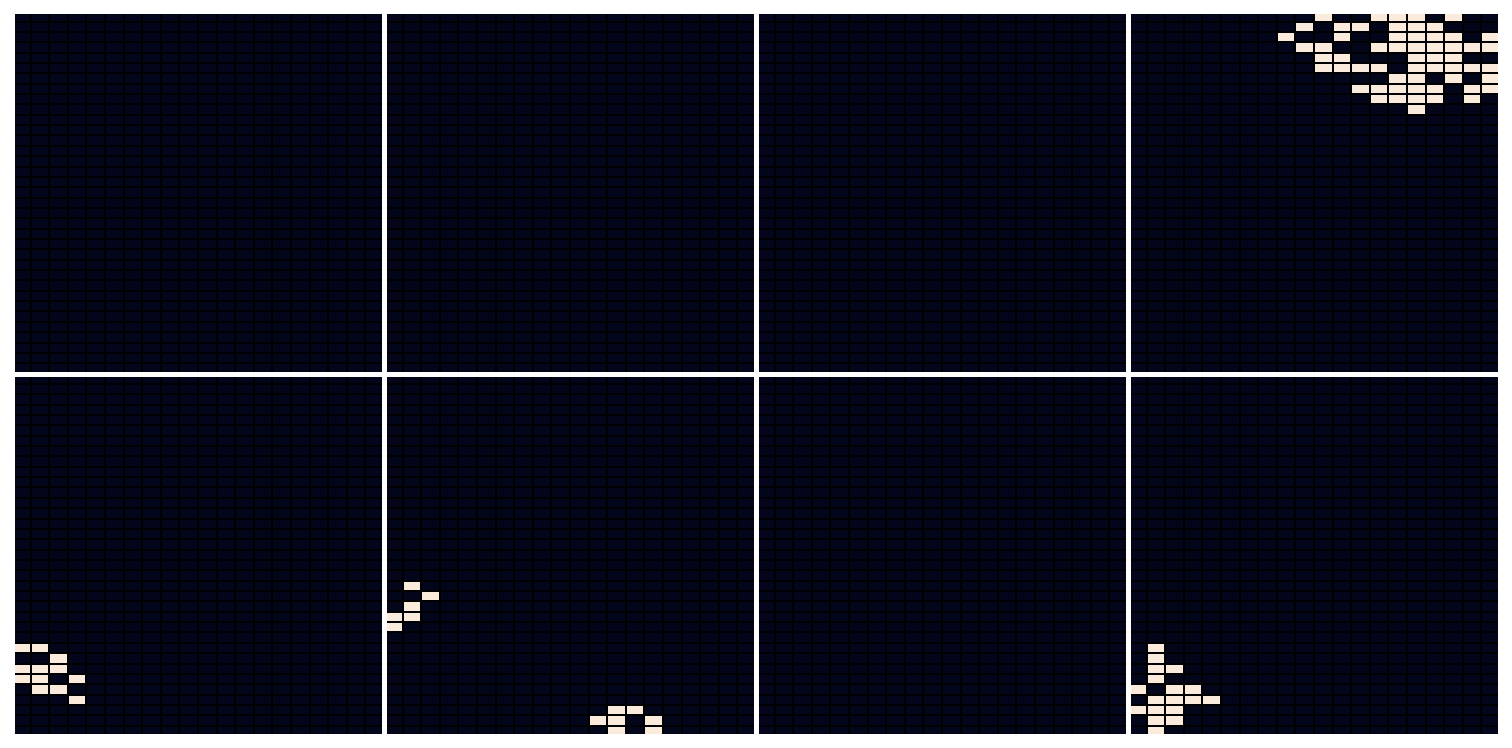

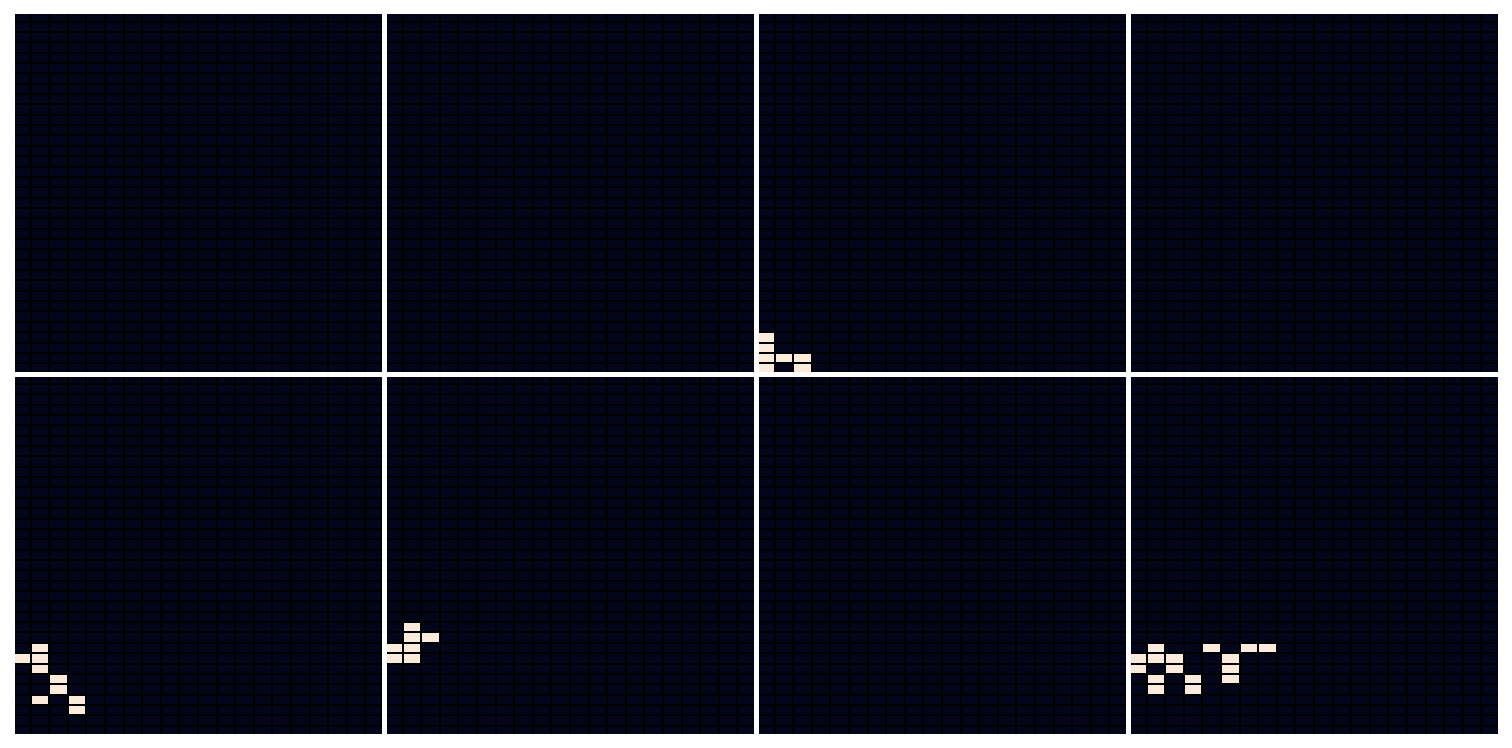

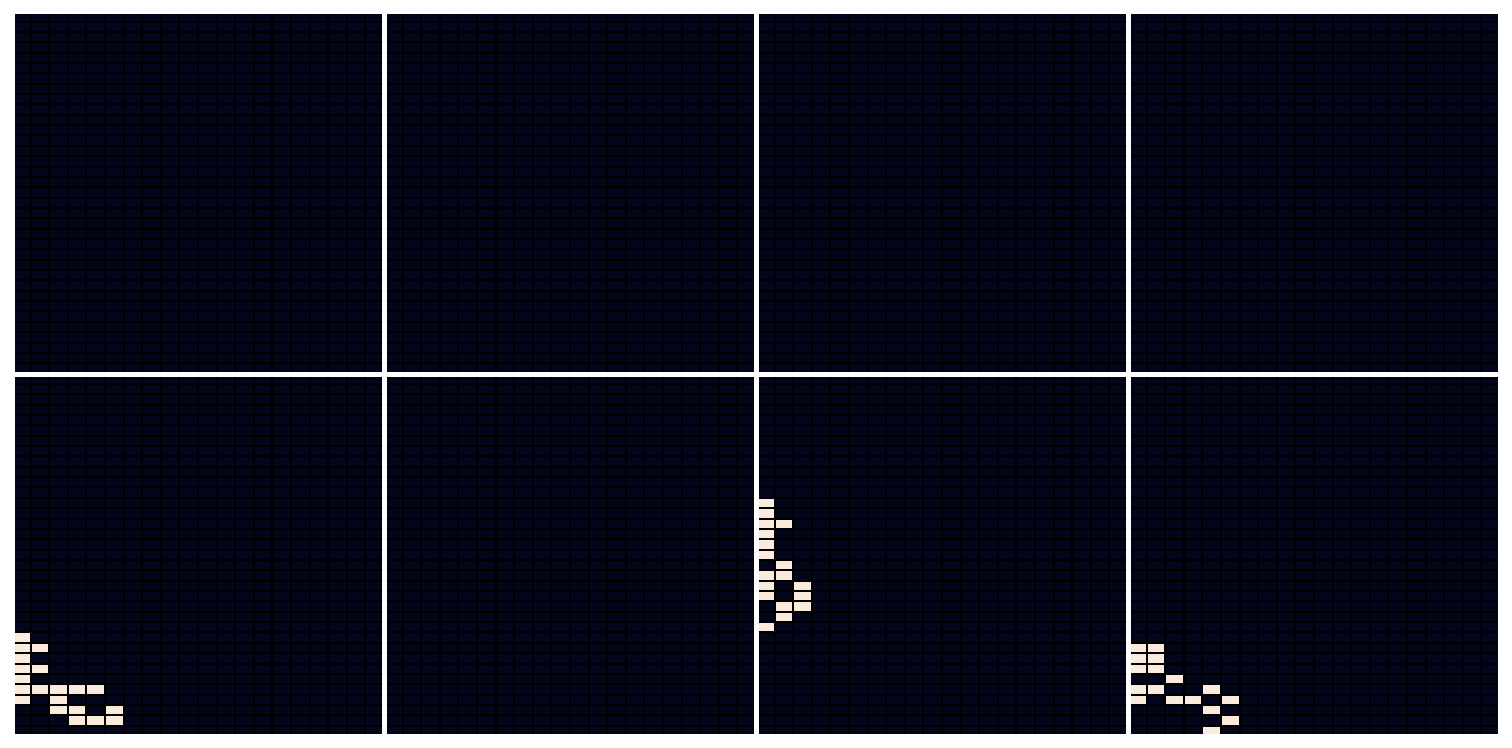

In [22]:
nuclear_area_mask = connected_components_analysis("nuclear_area")

<Figure size 432x288 with 0 Axes>

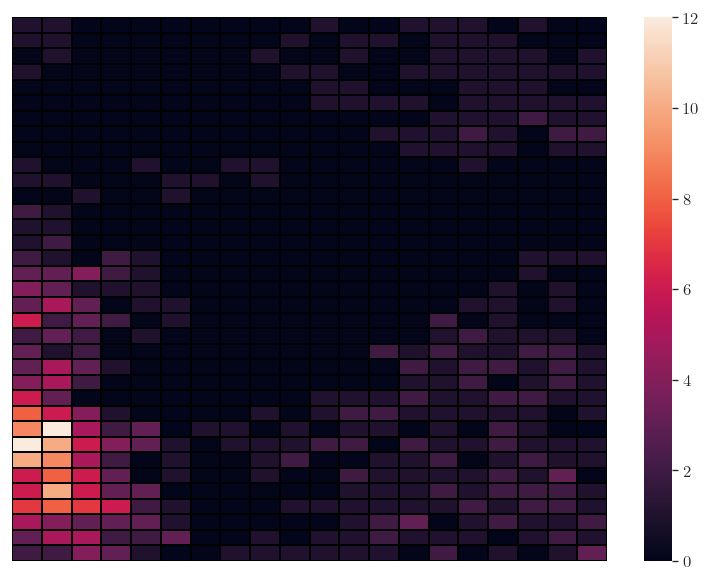

In [19]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=120)
sns.heatmap(
    nuclear_area_mask, ax=ax, linewidths=1, 
    linecolor='black', xticklabels=False, yticklabels=False, 
)
plt.show()

### Splotch Analysis Takeaway
Observing the spatial coherence of these data when such structure is unexpected, we recommend investigating the experimental setup to determine if there were potential issues with the apparatus or in the collection procedure. Downstream analysis is sullied as a result of the presence of such seeming experimental error, from which incorrect conclusions may be drawn. While discarding such regions of the data is a naive way to patch this issue, it suffers from the clear drawback of throwing away what should be valid data, further reducing sample sizes for assessing significances of ECMP/ligand interactions.

# Treatment Effect Analysis
In this section, we discuss our analysis of the treatment effect of each perturbation, where a perturbation is an ECMp-ligand pair. Recall that the control ECMp-ligand pair is *COL1-FBS*. Given an ECMp-ligand pair, we study the treatment effect of that pair with respect to the control pair. On a practical level, our goal from this analysis is to study if there exists any particular treatment that stands out and warrants special investigation. For our analysis, we focus only on the treatment effect on variables 'cell count' and 'nuclei area' as these variables are important indicators for cancer development. Furthermore, as these variables are shared across all staining sets, we can perform a cross-stain analysis for these variables. 



 Let $Y$ denote the variable for which we want to study the treatment effect and $\mathcal{T}$ denote the treatment variable with $t_0$ indicating the control pair. Initially, for a given treatment, we studied the average treatment effect (ATE),
$$\tau := \mathbb{E}[Y \mid \mathcal{T} = t] - \mathbb{E}[Y \mid \mathcal{T} = t_0]. $$
Note that this statistical estimand is actually the treatment effect  because we do not have confounding. This is true because the treatment (ECMp-ligand pair) is randomly assigned, and thus the treatment does not have a cause. As there are $15$ samples for each treatment pair, we used the following estimator for ATE
$$\hat{\tau} = \frac{1}{15} \sum_{n=1}^{15}  Y_{n,t} -  \frac{1}{15} \sum_{n=1}^{15}Y_{n, t_0}  . $$
However, upon further analysis, we realized that the variance of $\{Y_{n,t}\}_{n=1}^{15}$ is as large as its average, and thus the point estimate of $\tau$ might be misleading.

In [9]:
def combine_stain(k):
    df= pd.concat([plates[plate] for plate in staining_sets[k]])
    df = df[(df.ECMp != "air") &  (df.ECMp != "gelatin")]
    return df
        

In [10]:
def significant_ecmp_ligand(df, var):
    ecmp_ligand = df.groupby(['ECMp', 'Ligand1'])
    control = ecmp_ligand.get_group(('COL1', 'FBS_pubchemsid56314508'))
    names = list(ecmp_ligand.groups)
    p_values = []
    for name, group in ecmp_ligand:
      result = stats.anderson_ksamp([control[var], group[var]], midrank = True)
      p_values.append(result[2])

    idx = (np.isnan(p_values)-1)*-1
    names = np.delete(names, idx, axis =0).tolist()
    p_values = np.delete(p_values, idx)

    results = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    insignificant_indices = np.nonzero((results[0]-1)*(-1))
    names_reject = np.delete(names, insignificant_indices, axis =0).tolist()
    
    pvalues_reject = np.delete(p_values, insignificant_indices)
    significant_ecmps = np.asarray(np.unique(np.array(names_reject)[:, 0], return_counts = True)).T
    significant_ligands = np.asarray(np.unique(np.array(names_reject)[:, 1], return_counts = True)).T
    return significant_ecmps, significant_ligands, names_reject

In [17]:
stain1 = combine_stain(1)
sig_ecmp, sig_ligand, pairs= significant_ecmp_ligand(stain1, "Spot_PA_SpotCellCount")
sig_ecmp = sig_ecmp[sig_ecmp[:, 1].astype(float).argsort()[::-1]]
sig_ligand = sig_ligand[sig_ligand[:, 1].astype(float).argsort()[::-1]]
#pd.DataFrame(pairs).to_csv("significant3.csv")
#print(len(pairs))
#print(sig_ecmp[:5])
#print(sig_ligand[:5])

Instead, to use information from both averages as well as variability, we used two sample distributional tests to quantify the treatment effect. In particular, for each  treatment $\mathcal{T} =t$, we did the hypothesis testing for the hypotheses'
$$H_0: \{Y_{n,t}\}_{n=1}^{15} \sim \{Y_{n,t_0}\}_{n=1}^{15} \quad \quad H_A: \{Y_{n,t}\}_{n=1}^{15} \not \sim \{Y_{n,t_0}\}_{n=1}^{15}, $$
where we use $\sim$ to denote that two samples come from the same underlying distribution.
For the two-sample test, we chose the Anderson-Darling test, which is a non-parametric test that compares a weighted version of the empirical CDF between two samples. We chose this test over the more popular Kolmogorov-Smirnov because the A-D test is known to handle discrete data better than the K-S test. As there are $2736$ treatments, we have a multiple testing problem. So, we did a Benjamini-Hochberg adjustment to control the false discovery rate at $0.05$.

<br>

| Stain    | Significant treatments | Significant ECMps | Significant ligands|
| ----------- | ----------- | ----------- | ----------- |
| 1 | 700 | ELN3, NID1, FN1 | BMP2P1, GPNMB1, IGF11  |
| 2 | 488 | ELN3, NID1, FBN1| NRG16Q, NRG11Q, BMP2P|
| 3 | 283 | ELN3, NID1, COL5A1|  CSF2P0, BMP51P2, FGF23P|

<p style="text-align:center"> Table 1: Summary of treatment effect analysis for the variable 'cell count' </p>

<br>

From Table 1, we observe that the ECMps `ELN|3` and `NID1` are most significant across all three staining sets. However, we do not observe any ligand that stands out in all staining sets. 
Additionally, we summarize the actual effect of these two treatment ECMps for the variable 'cell count' in Table 2. As we can see, these two ECMps have a smaller average cell count compared to that of their complements. So, we have strong preliminary evidence to suggest that these two treatments are effective.

<br>

| Stain    | ELN3 | $\neg$ELN3 | NID1| $\neg$ NID1|
| ----------- | ----------- | ----------- | ----------- | -----------|
| 1 | 78 | 149 | 106 | 148|
| 2 | 217 | 369 | 224 | 368|
| 3 | 49 | 76 | 30 | 76|

<p style="text-align:center"> Table 2: Average cell count for two treatment ECMps and their complements. Here, $\neg$ ELN3 denotes the average cell count of all treatment ECMps except ELN3. </p>

<br>
Moreover, we repeated this exact same analysis for the variable 'nuclei area' and observed that `ELN3` and `NID1` are indeed the most significant ECMps for the 'nuclei area' variable as well.  Thus, in view of our findings,  we recommend getting more perturbation samples for these two treatment ECMps in the future run of the experiments. This will allow us to study the finer effects of this treatment. 

# Linear Model Fit

We fit linear models of the form 
\begin{align*}
  y_{ijkl} = \alpha_i + \beta_j + \gamma_k + \epsilon_{ijkl} \tag{1}
\end{align*}
and of the more complicated form
\begin{align*}
  y_{ijkl} = \alpha_i + \beta_j + \theta_{ij} + \gamma_k + \epsilon_{ijkl}. \tag{2}
\end{align*}
where $y_{ijkl}$ is the measurement of a given variable for the $l$th replicate of a group of cells in staining set $k$ treated with ECMp $i$ and ligand $j$. The $\epsilon_{ijkl}$ are i.i.d. and follow a normal distribution with mean 0. 

The intercept estimates the average value of the dependent variable measured for cells in staining set 1 treated with COL1 and FBS. Note that this treatment uses the control ECMp and control ligand, which makes it a natural baseline for comparison. 

The plots and tables of estimates which follow are for model $(1)$.

## Nuclei_CP_AreaShape_Area model

We'd like to determine whether the ECMp-ligand interactions are worth keeping in the model. The unimportance of such interactions may suggest that further analysis can ignore interactions. 

Based on the following output, model $(1)$ has superior AIC. However, the F-test suggests keeping interaction effects. 

Nuclei_CP_AreaShape_Area  interactions model summary: 
                 Df    Sum Sq   Mean Sq   F value Pr(>F)    
ECM1             49 2.093e+08 4.272e+06   120.501 <2e-16 ***
Ligand1          56 2.740e+08 4.892e+06   137.999 <2e-16 ***
stain_num         2 3.394e+09 1.697e+09 47874.105 <2e-16 ***
ECM1:Ligand1   2744 1.379e+08 5.024e+04     1.417 <2e-16 ***
Residuals    131034 4.645e+09 3.545e+04                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC:  1785351 ; Adjusted R^2:  0.4519731 

Nuclei_CP_AreaShape_Area  model summary: 
                Df    Sum Sq   Mean Sq F value Pr(>F)    
ECM1            49 2.093e+08 4.272e+06   119.5 <2e-16 ***
Ligand1         56 2.740e+08 4.892e+06   136.8 <2e-16 ***
stain_num        2 3.394e+09 1.697e+09 47467.8 <2e-16 ***
Residuals   133778 4.783e+09 3.575e+04                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC:  1783779 ; Adjusted R^2:  0.4472824 



|Type        |Treatment |

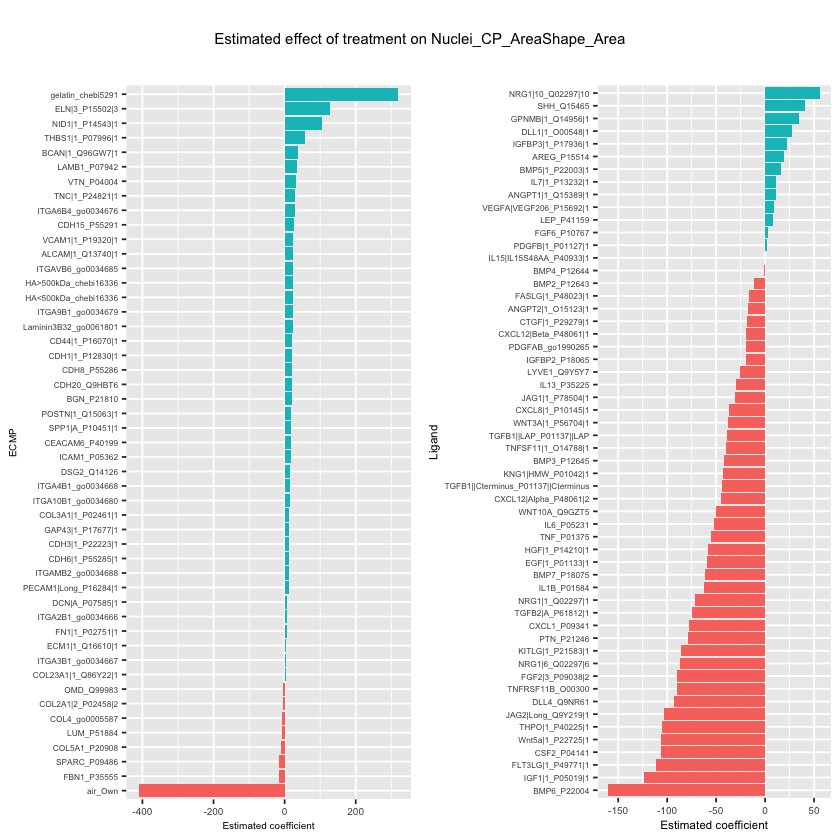

In [5]:
var_name = "Nuclei_CP_AreaShape_Area"
fit_big_lm = TRUE 
print_aov_summary = TRUE

  lm_super_tbl = super_tbl %>%
  mutate(ECM1 = as.factor(ECM1) %>% 
           relevel(ref = "COL1_go0005584")) %>%
  mutate(Ligand1 = as.factor(Ligand1) %>% 
           relevel(ref = "FBS_pubchemsid56314508")) %>%
    filter(!is.na(.[[var_name]]))

  # ~13.5 minutes
  if(fit_big_lm){
    if(length(unique(lm_super_tbl$stain_num)) == 1){
      area_treatment_lm = aov(
        lm_super_tbl[[var_name]] ~ ECM1*Ligand1,
        data = lm_super_tbl
      )
    } else {
      area_treatment_lm = aov(
        lm_super_tbl[[var_name]] ~ ECM1*Ligand1+stain_num,
        data = lm_super_tbl
      )
    }
    if(print_aov_summary){
      cat(var_name, " interactions model summary: \n")
      print(summary(area_treatment_lm))
      cat("AIC: ", AIC(area_treatment_lm), 
          "; Adjusted R^2: ", summary.lm(area_treatment_lm)$adj.r.squared,
          "\n\n")
    }
  }
  
  if(length(unique(lm_super_tbl$stain_num)) == 1){
    simple_area_treatment_lm = aov(
      lm_super_tbl[[var_name]] ~ ECM1+Ligand1,
      data = lm_super_tbl
    )
  } else {
    simple_area_treatment_lm = aov(
      lm_super_tbl[[var_name]] ~ ECM1+Ligand1+stain_num,
      data = lm_super_tbl
    )
  }
  if(print_aov_summary){
    cat(var_name, " model summary: \n")
    print(summary(simple_area_treatment_lm))
    cat("AIC: ", AIC(simple_area_treatment_lm), 
        "; Adjusted R^2: ", summary.lm(simple_area_treatment_lm)$adj.r.squared,
        "\n\n")  
  }
  
  simple_coefficients_tbl = tibble(
    coefficient = names(simple_area_treatment_lm$coefficients),
    Value = simple_area_treatment_lm$coefficients
  ) %>%
    extract(col = coefficient, 
             into = c("Type", "Treatment"),
             regex = "(Ligand1|ECM1|stain_num|\\(Intercept\\))(.*)") %>%
    mutate(Positive = Value > 0)
  
  simple_coefficients_tbl %>%
    filter(Type == "(Intercept)" | Type == "stain_num") %>%
    select(!Positive) %>%
    kable() %>%
    print()
  
  gg1 = ggplot(simple_coefficients_tbl %>% 
        filter(Type == "ECM1") %>%
        mutate(Treatment = fct_reorder(factor(Treatment), Value)),
    aes(x = Value, y = Treatment, fill = Positive)) +
    geom_col() + 
    theme(legend.position = "none", axis.text.y = element_text(size=5),
          axis.text.x = element_text(size=6),
          plot.title = element_text(size = 10),
          axis.title = element_text(size = 6)) + 
    ylab("ECMP") + 
    xlab("Estimated coefficient")
    
  gg2 = ggplot(simple_coefficients_tbl %>% 
        filter(Type == "Ligand1") %>%
        mutate(Treatment = fct_reorder(factor(Treatment), Value)),
    aes(x = Value, y = Treatment, fill = Positive)) +
    geom_col() + 
    theme(legend.position = "none", axis.text.y = element_text(size=5),
          axis.text.x = element_text(size=6),
          plot.title = element_text(size = 10), 
          axis.title = element_text(size = 7)) + 
    ylab("Ligand") + 
    xlab("Estimated coefficient")
  gg_grid = plot_grid(gg1, gg2)
  gg_title = ggdraw() + 
    draw_label(paste0("Estimated effect of treatment on ", var_name),
               size = 9)
  print(plot_grid(gg_title, gg_grid, ncol=1, rel_heights=c(0.1, 1)))

## Spot_PA_SpotCellCount model

Once again, the simpler linear model has superior AIC while the F-test suggests keeping interaction effects.

Spot_PA_SpotCellCount  interactions model summary: 
                 Df    Sum Sq   Mean Sq   F value   Pr(>F)    
ECM1             49 6.687e+07 1.365e+06 2.303e+02  < 2e-16 ***
Ligand1          56 4.918e+07 8.782e+05 1.482e+02  < 2e-16 ***
stain_num         2 2.016e+09 1.008e+09 1.701e+05  < 2e-16 ***
ECM1:Ligand1   2744 1.767e+07 6.439e+03 1.087e+00 0.000985 ***
Residuals    131034 7.765e+08 5.926e+03                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC:  1545857 ; Adjusted R^2:  0.7288276 

Spot_PA_SpotCellCount  model summary: 
                Df    Sum Sq   Mean Sq  F value Pr(>F)    
ECM1            49 6.687e+07 1.365e+06    229.9 <2e-16 ***
Ligand1         56 4.918e+07 8.782e+05    147.9 <2e-16 ***
stain_num        2 2.016e+09 1.008e+09 169762.5 <2e-16 ***
Residuals   133778 7.942e+08 5.937e+03                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC:  1543382 ; Adjusted R^2:  0.7283458 



|Type        |

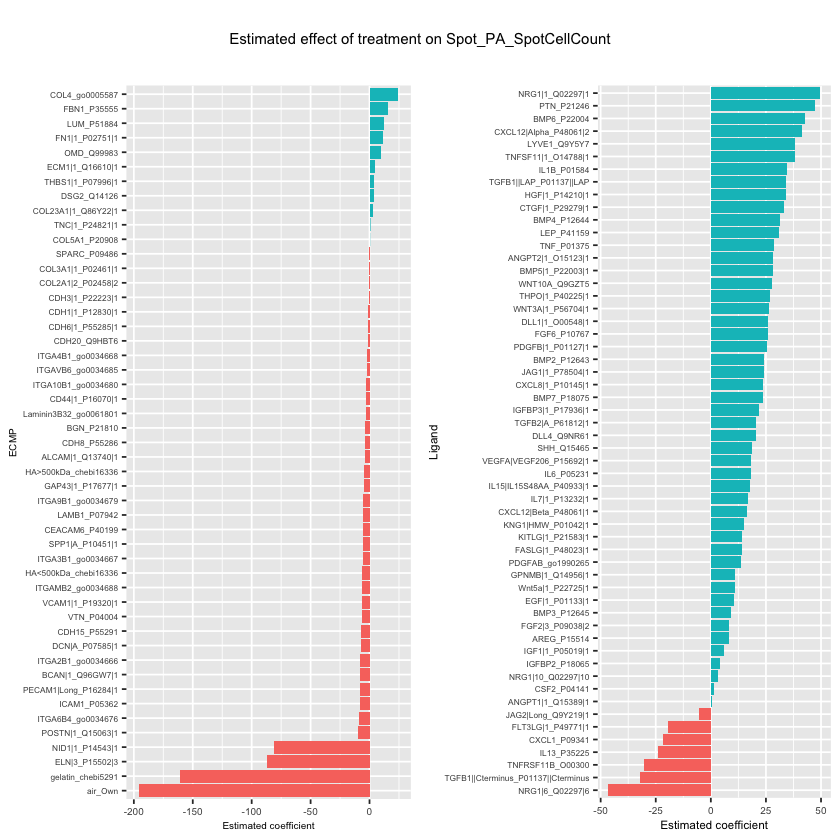

In [6]:
var_name = "Spot_PA_SpotCellCount"
fit_big_lm = TRUE 
print_aov_summary = TRUE

  lm_super_tbl = super_tbl %>%
  mutate(ECM1 = as.factor(ECM1) %>% 
           relevel(ref = "COL1_go0005584")) %>%
  mutate(Ligand1 = as.factor(Ligand1) %>% 
           relevel(ref = "FBS_pubchemsid56314508")) %>%
    filter(!is.na(.[[var_name]]))

  # ~13.5 minutes
  if(fit_big_lm){
    if(length(unique(lm_super_tbl$stain_num)) == 1){
      area_treatment_lm = aov(
        lm_super_tbl[[var_name]] ~ ECM1*Ligand1,
        data = lm_super_tbl
      )
    } else {
      area_treatment_lm = aov(
        lm_super_tbl[[var_name]] ~ ECM1*Ligand1+stain_num,
        data = lm_super_tbl
      )
    }
    if(print_aov_summary){
      cat(var_name, " interactions model summary: \n")
      print(summary(area_treatment_lm))
      cat("AIC: ", AIC(area_treatment_lm), 
          "; Adjusted R^2: ", summary.lm(area_treatment_lm)$adj.r.squared,
          "\n\n")
    }
  }
  
  if(length(unique(lm_super_tbl$stain_num)) == 1){
    simple_area_treatment_lm = aov(
      lm_super_tbl[[var_name]] ~ ECM1+Ligand1,
      data = lm_super_tbl
    )
  } else {
    simple_area_treatment_lm = aov(
      lm_super_tbl[[var_name]] ~ ECM1+Ligand1+stain_num,
      data = lm_super_tbl
    )
  }
  if(print_aov_summary){
    cat(var_name, " model summary: \n")
    print(summary(simple_area_treatment_lm))
    cat("AIC: ", AIC(simple_area_treatment_lm), 
        "; Adjusted R^2: ", summary.lm(simple_area_treatment_lm)$adj.r.squared,
        "\n\n")  
  }
  
  simple_coefficients_tbl = tibble(
    coefficient = names(simple_area_treatment_lm$coefficients),
    Value = simple_area_treatment_lm$coefficients
  ) %>%
    extract(col = coefficient, 
             into = c("Type", "Treatment"),
             regex = "(Ligand1|ECM1|stain_num|\\(Intercept\\))(.*)") %>%
    mutate(Positive = Value > 0)
  
  simple_coefficients_tbl %>%
    filter(Type == "(Intercept)" | Type == "stain_num") %>%
    select(!Positive) %>%
    kable() %>%
    print()
  
  gg1 = ggplot(simple_coefficients_tbl %>% 
        filter(Type == "ECM1") %>%
        mutate(Treatment = fct_reorder(factor(Treatment), Value)),
    aes(x = Value, y = Treatment, fill = Positive)) +
    geom_col() + 
    theme(legend.position = "none", axis.text.y = element_text(size=5),
          axis.text.x = element_text(size=6),
          plot.title = element_text(size = 10),
          axis.title = element_text(size = 6)) + 
    ylab("ECMP") + 
    xlab("Estimated coefficient")
    
  gg2 = ggplot(simple_coefficients_tbl %>% 
        filter(Type == "Ligand1") %>%
        mutate(Treatment = fct_reorder(factor(Treatment), Value)),
    aes(x = Value, y = Treatment, fill = Positive)) +
    geom_col() + 
    theme(legend.position = "none", axis.text.y = element_text(size=5),
          axis.text.x = element_text(size=6),
          plot.title = element_text(size = 10), 
          axis.title = element_text(size = 7)) + 
    ylab("Ligand") + 
    xlab("Estimated coefficient")
  gg_grid = plot_grid(gg1, gg2)
  gg_title = ggdraw() + 
    draw_label(paste0("Estimated effect of treatment on ", var_name),
               size = 9)
  print(plot_grid(gg_title, gg_grid, ncol=1, rel_heights=c(0.1, 1)))

In [47]:
all_data <- all_data %>%
  relocate(StainingSet, .before = 1) %>%
  mutate(
    ss_num = case_when(
      StainingSet == "SS1Layout1Set1" ~ 1L,
      StainingSet == "SS2noH3Layout1Set1" ~ 2L,
      StainingSet == "SS3Layout1Set3" ~ 3L
    )
  ) %>%
  relocate(ss_num, .after = StainingSet) %>%
  group_by(ss_num) %>%
  mutate(plate_num = dense_rank(plate)) %>%
  ungroup() %>%
  relocate(plate_num, .after = plate) %>%
  arrange(ss_num, plate_num)

<!-- Create one tibble for each staining set. -->

In [48]:
all_data2 <- nest(all_data, data = !c(StainingSet, ss_num))
with(
  all_data2,
  walk2(
    ss_num, data,
    function(ss_num, data) {
      assign(str_interp("ss${ss_num}_data"), data, .GlobalEnv)
    }
  )
)

# Dimensionality Reduction

<!-- ## Variable Scales -->

<!-- These seem to be the numeric ID columns; these should be excluded when doing PCA. -->

In [57]:
numeric_id_cols <- all_data %>%
  select(
    where(is.numeric) &
      !matches("^(Cells|Cytoplasm|Nuclei)_(CP|PA)_") &
      !matches("(Diameter|Conc|TimeReact)$") &
      !matches("^Spot_PA_") &
      !QAScore
  ) %>%
  names()

[1] "ss_num"      "plate_num"   "WellIndex"   "ArrayRow"    "ArrayColumn"
[6] "Spot"        "PrintSpot"   "ImageID"     "ClarionID"

## PCA

<!-- Define functions for running PCA and plotting the results of PCA. -->

In [62]:
run_pca <- function(data, pattern = ".*") {
  data %>%
    select(
      where(is.numeric) &
        where(~ !any(is.na(.x))) &
        where(~ n_distinct(.x) > 1) &
        !any_of(numeric_id_cols) &
        matches(pattern)
    ) %>%
    prcomp(scale. = TRUE)
}

make_prop_var_explained_plot <- function(pca_results, title) {
  plot <- pca_results %>%
    `$`("sdev") %>%
    `^`(2) %>%
    {cumsum(.) / sum(.)} %>%
    enframe(name = "num_pcs", value = "prop_var_explained") %>%
    ggplot(aes(num_pcs, prop_var_explained)) +
    geom_point() +
    geom_line() +
    geom_hline(linetype = "dashed", yintercept = 0.95) +
    labs(
      x = "Number of PCs", y = "Proportion of Variation Explained",
      title = title
    ) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
  brks <- layer_scales(plot)$y$get_breaks()
  plot + scale_y_continuous(breaks = c(brks, 0.95))
}

make_first_pc_loadings_plot <- function(pca_results, title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, "PC1") %>%
    enframe(name = "col", value = "loading") %>%
    ggplot(aes(loading)) +
    geom_histogram(color = "black", fill = "lightgray", binwidth = 0.01) +
    labs(x = "PC1 Loading", y = "Number of Variables", title = title) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot_no_pattern <- function(pca_results, title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, c("PC1", "PC2")) %>%
    as_tibble(rownames = "col") %>%
    rename(loading1 = PC1, loading2 = PC2) %>%
    ggplot(aes(loading1, loading2)) +
    geom_point() +
    labs(x = "PC1 Loading", y = "PC2 Loading", title = title) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot_pattern <- function(pca_results,
                                                    pattern,
                                                    title) {
  pca_results %>%
    `$`("rotation") %>%
    `[`(, c("PC1", "PC2")) %>%
    as_tibble(rownames = "col") %>%
    rename(loading1 = PC1, loading2 = PC2) %>%
    mutate(
      col_parts = str_split(col, "_"),
      subset1 = map_chr(col_parts, 1),
      subset2 = map_chr(col_parts, 3)
    ) %>%
    select(!col_parts) %>%
    select(where(~ !all(str_detect(.x, pattern)))) %>%
    rename_with(str_remove, starts_with("subset"), pattern = "\\d$") %>%
    ggplot(aes(loading1, loading2, color = subset)) +
    geom_point() +
    labs(
      x = "PC1 Loading", y = "PC2 Loading",
      color = "Subset",
      title = title
    ) +
    theme_bw() +
    theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5))
}

make_first_2_pcs_loadings_plot <- function(pca_results, pattern = ".*", title) {
  if (pattern == ".*") {
    make_first_2_pcs_loadings_plot_no_pattern(pca_results, title)
  } else {
    make_first_2_pcs_loadings_plot_pattern(pca_results, pattern, title)
  }
}

make_pca_results_plot <- function(pca_results, pattern = ".*", title) {
  panel1 <- make_prop_var_explained_plot(pca_results, title = NULL)
  panel2 <- make_first_pc_loadings_plot(pca_results, title = NULL)
  panel3 <- make_first_2_pcs_loadings_plot(pca_results, pattern, title = NULL)
  
  legend <- get_legend(panel3)
  if (is.null(legend)) {
    return(arrangeGrob(panel1, panel2, panel3, nrow = 1, top = title))
  }
  panel3 <- panel3 + theme(legend.position = "none")
  plot_grid(
    arrangeGrob(panel1, panel2, panel3, nrow = 1, top = title),
    legend,
    ncol = 1,
    rel_heights = c(9, 1)
  )
}

make_pca_results_plots <- function(pattern = ".*", ss_nums = 1:3) {
  if (pattern == ".*") {
    title_template <- "PCA Results for Staining Set ${.x}, All Variables"
  } else {
    title_template <- 
      "PCA Results for Staining Set ${.x}, ${pattern} Variables Only"
  }
  all_data2 %>%
    filter(ss_num %in% ss_nums) %>%
    mutate(
      pca_results = map(data, run_pca, pattern = pattern),
      title = map_chr(ss_num, ~ str_interp(title_template)),
      pca_results_plot = map2(
        pca_results, title, make_pca_results_plot, pattern = pattern
      )
    )
}

We first ran PCA using all non-trivial numeric variables. We considered a numeric variable to be non-trivial if it wasn't an ID variable, didn't have any missing values, and had more than one unique value. Each variable was centered and scaled beforehand. Because of the differences we observed between staining sets, we carried out PCA separately for the different staining sets. The plots below show the results of PCA for all non-trivial numeric variables. In the left-hand panels, we see that the first 20-30 principal components (PCs) capture around 95\% of the variation for each staining set. The middle panels show the loadings for the first PC. Every PC can be expressed as a linear combination of the original variables; the coefficients in the linear combination are called loadings. Ideally, most loadings would be close to zero, and only a few would have non-trivial magnitudes. Then, interpretation of the PC in terms of the original variables would be simple. However, this was not the case; many of the loadings were non-trivial. The right-hand panels plot the PC2 loading versus the PC1 loading for each variable. It would be interesting if the variables lay in clusters, but this isn't the case below.

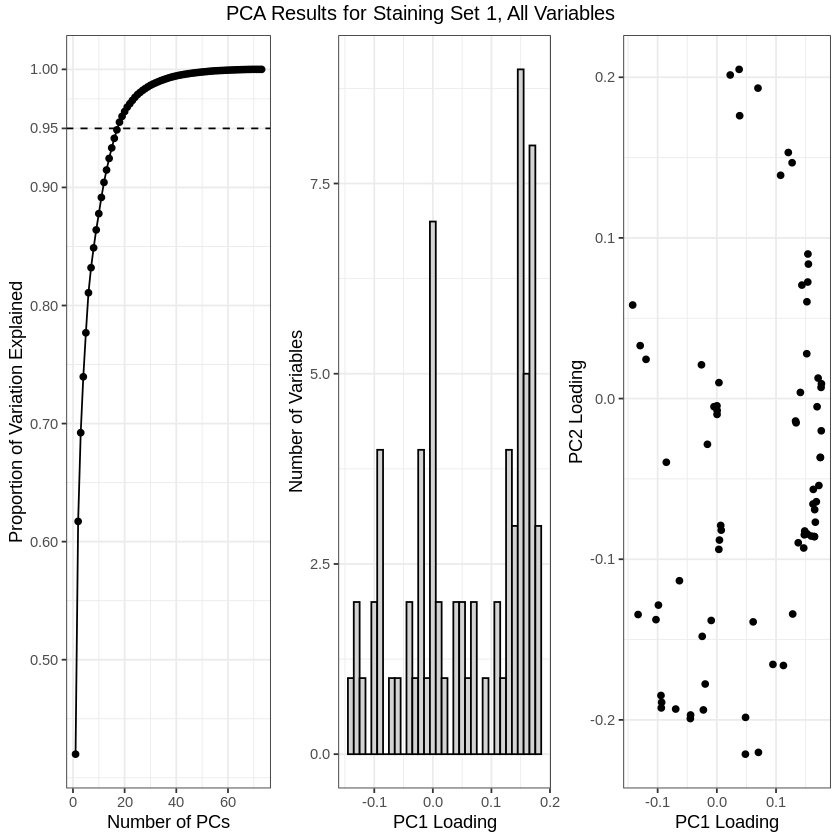

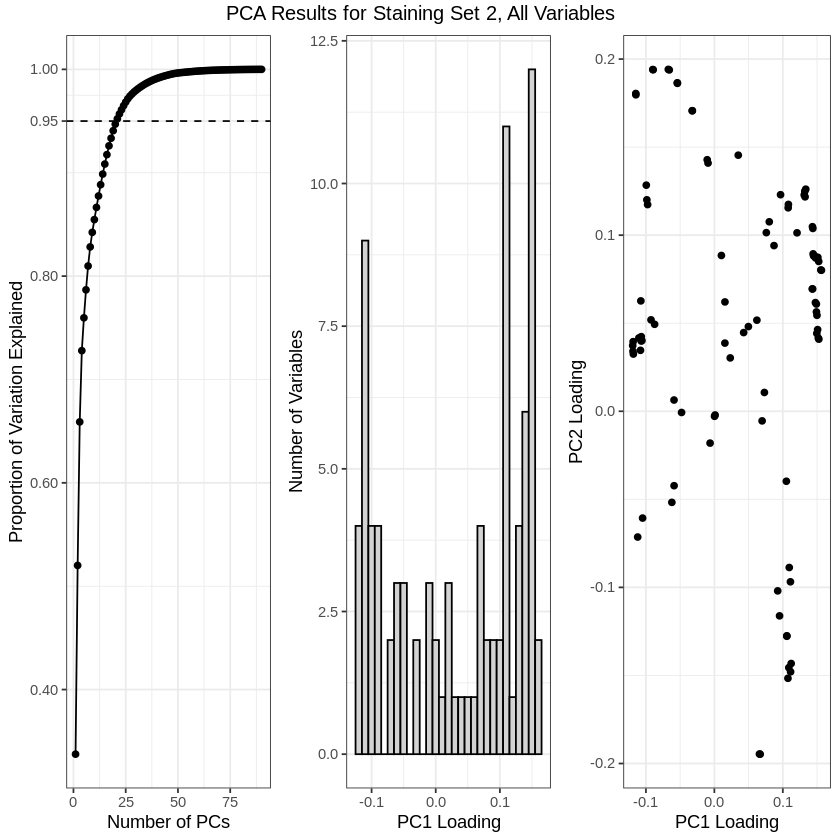

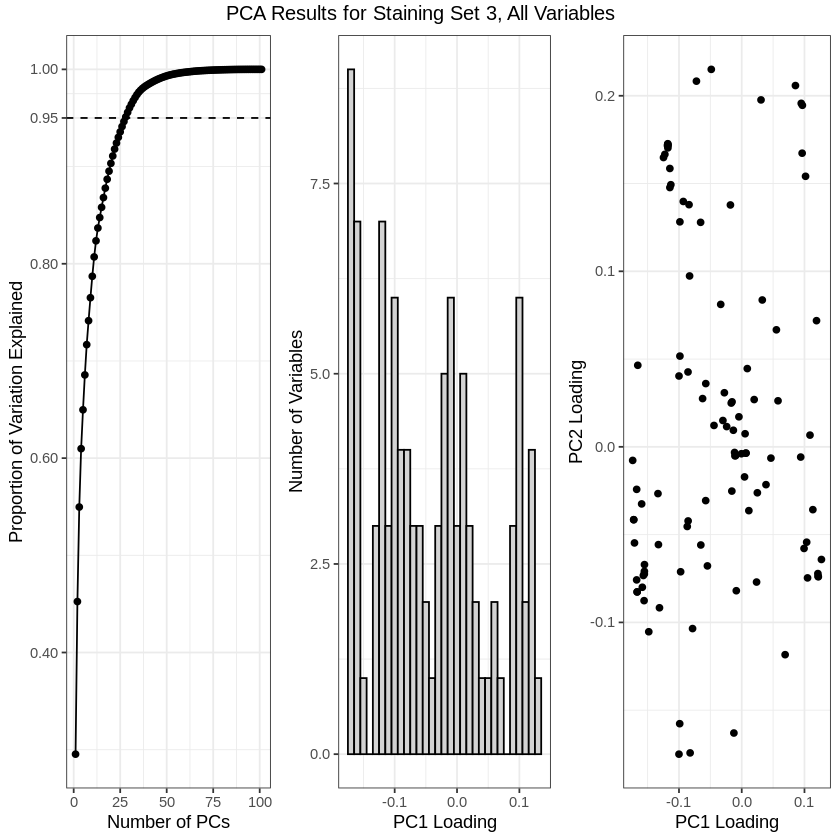

In [63]:
make_pca_results_plots() %>%
  with(walk(pca_results_plot, grid.arrange))

For several subsets of the variables, we ran PCA in the same way that we did for the full set of non-trivial numeric variables. We performed PCA for subsets consisting of variables measuring quantities of the same nature, like the AreaShape variables and the Texture variables. We also performed PCA for subsets consisting of variables for the same cell part, like cytoplasm variables and nuclei variables. For the most part, the results for these subsets looked like the results for the full set of variables. For the different staining sets, a relatively small number of principal components capture the bulk of the variation in the data, and plots of the loadings show no interesting patterns. However, for the Texture variables, which were only measured for staining set 2, the plot of the PC1 and PC2 loadings seems to suggest that the variables can be partitioned into three clusters. Plots of the PCA results for this subset are given below.

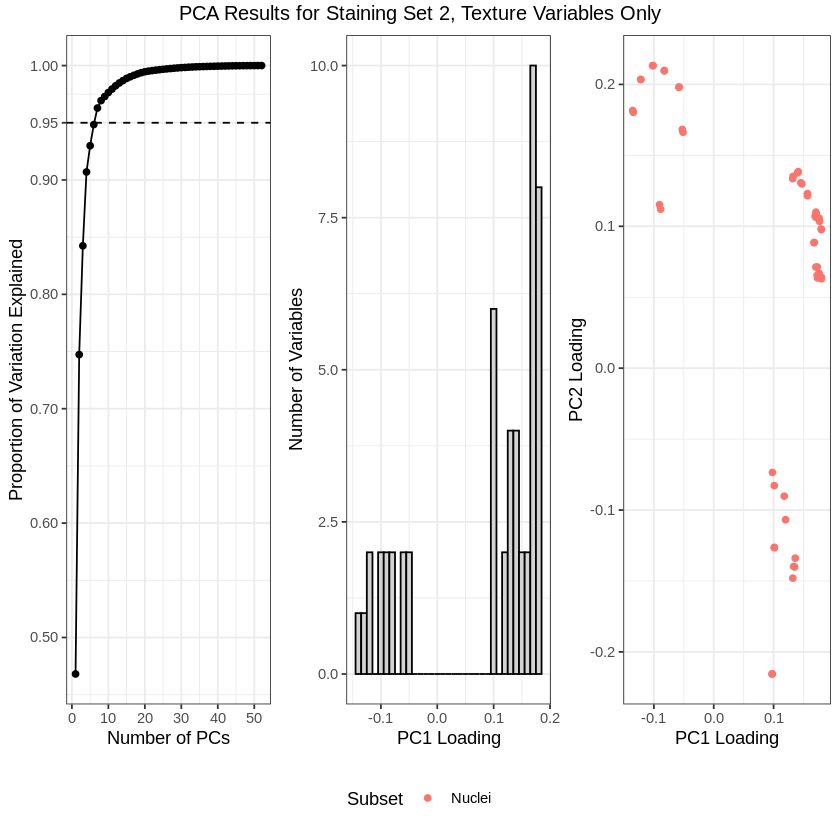

In [70]:
make_pca_results_plots(pattern = "Texture", ss_nums = 2) %>%
  with(walk(pca_results_plot, grid.arrange))

# Outlier Detection

In [77]:
make_outlyingness_plot <- function(plate_num,
                                   plate_data,
                                   plot_type = c(
                                     "outlyingness", "flag"
                                   )) {
  if (plot_type == "outlyingness") {
    col <- as.name("outlyingness")
    fill_lab <- "Outlyingness"
  } else {
    col <- as.name("is_outlier")
    fill_lab <- "Is Outlier?"
  }
  
  plate_data %>%
    ggplot(aes(ArrayColumn, ArrayRow, fill = !!col)) +
    facet_wrap(vars(Well), nrow = 2) +
    geom_tile() +
    labs(
      x = NULL, y = NULL,
      fill = fill_lab,
      title = str_interp("Plate ${plate_num}")
    ) +
    theme_bw() +
    theme(
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      plot.title = element_text(hjust = 0.5),
      strip.text = element_blank()
    )
}

make_outlyingness_plots <- function(ss_num,
                                    data,
                                    pattern,
                                    invariance_type = c(
                                      "Affine", "Rotation", "Shift"
                                    ),
                                    plot_type = c(
                                      "outlyingness", "flag"
                                    )
                                    ) {
  pca_results <- run_pca(data, pattern)
  lambdas <- pca_results$sdev^2
  num_pcs <- lambdas %>%
    {cumsum(.) / sum(.)} %>%
    `>=`(0.95) %>%
    which() %>%
    min()
  
  outlyingness_obj <- pca_results %>%
    `$`("x") %>%
    `[`(, seq_len(num_pcs)) %>%
    adjOutl(options = list(type = invariance_type))

  plots <- data %>%
    select(plate_num, Well, ArrayColumn, ArrayRow) %>%
    add_column(
      outlyingness = outlyingness_obj$outlyingnessX,
      is_outlier = !outlyingness_obj$flagX
    ) %>%
    nest(plate_data = !plate_num) %>%
    mutate(
      outlyingness_plot = map2(
        plate_num, plate_data,
        make_outlyingness_plot,
        plot_type = plot_type
      )
    ) %>%
    pull()

  if (pattern == ".*") {
    title <- str_interp("Staining Set ${ss_num}, All Variables")
  } else {
    title <- str_interp(
      "Staining Set ${ss_num}, ${pattern} Variables Only"
    )
  }
  title <- textGrob(title, gp = gpar(fontsize = 20))
  legend <- get_legend(plots[[1]] + theme(legend.position = "bottom"))
  plots %>%
    map(function(plot) plot + theme(legend.position = "none")) %>%
    plot_grid(plotlist = ., nrow = 2, ncol = 4) %>%
    plot_grid(title, ., legend, ncol = 1, rel_heights = c(1, 9, 1))
}

We sought to identify replicates that could be considered outliers with respect to their staining sets. We performed outlier detection by calculating a skew-adjusted version of a measure of outlyingness called the Stahel-Donoho outlyingness (SDO) for each replicate. In the univariate case, the ordinary SDO of an observation $x_i$ is
$$
\text{SDO}(x_i) := \frac{|x_i - \text{med}_j x_j|}{\text{med}_k |x_k - \text{med}_j x_j|}.
$$
In the multivariate case, the SDO of $\boldsymbol{x}_i$ is
$$
\text{SDO}(\boldsymbol{x}_i) := \sup_{\boldsymbol{u} \in \mathbb{R}^d} \frac{|\boldsymbol{x}_i^T \boldsymbol{u} - \text{med}_j \boldsymbol{x}_j^T \boldsymbol{u}|}{\text{med}_k |\boldsymbol{x}_k^T \boldsymbol{u} - \text{med}_j \boldsymbol{x}_j^T \boldsymbol{u}|}.
$$
The measure we used is a robust version of the ordinary multivariate SDO appropriate for skewed data. Since not all directions could be used in the computations, a subset of directions was used that was chosen in a random fashion. As in the dimensionality reduction section, we performed outlier detection for various subsets of the numeric variables.

The plots below show the results of outlier detection for the subset consisting of the AreaShape variables. Each plot shows, for a particular staining set, the distribution of the outliers across the wells of the different plates. In most wells, there are few outliers, and they're scattered seemingly randomly across the well. However, in some wells, there are large concentrations of outliers. The plots for the other variable subsets aren't shown here as they looked similar.

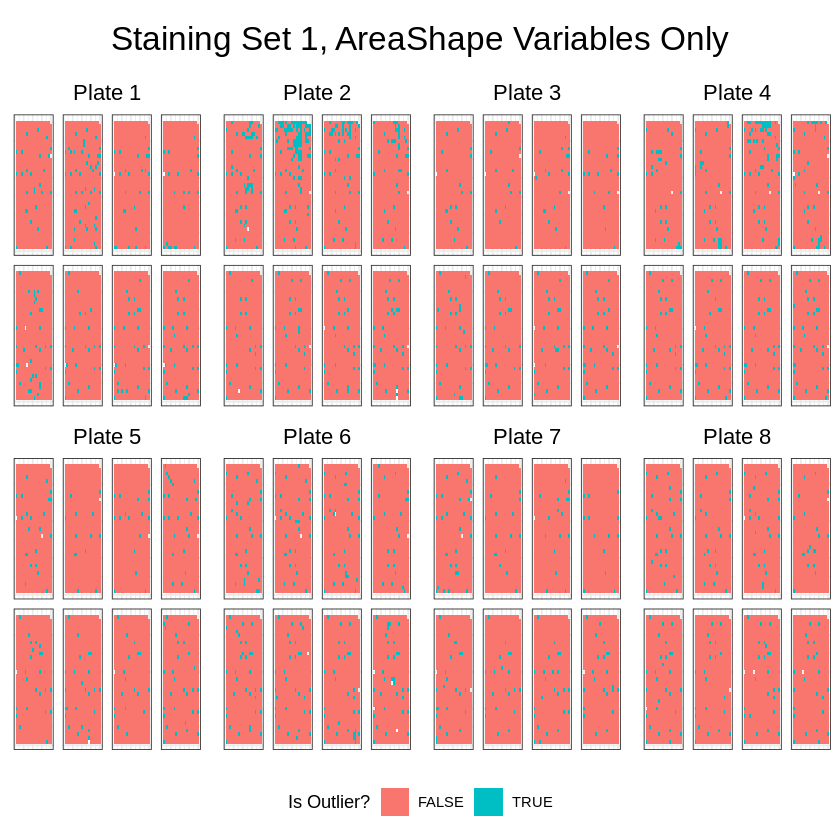

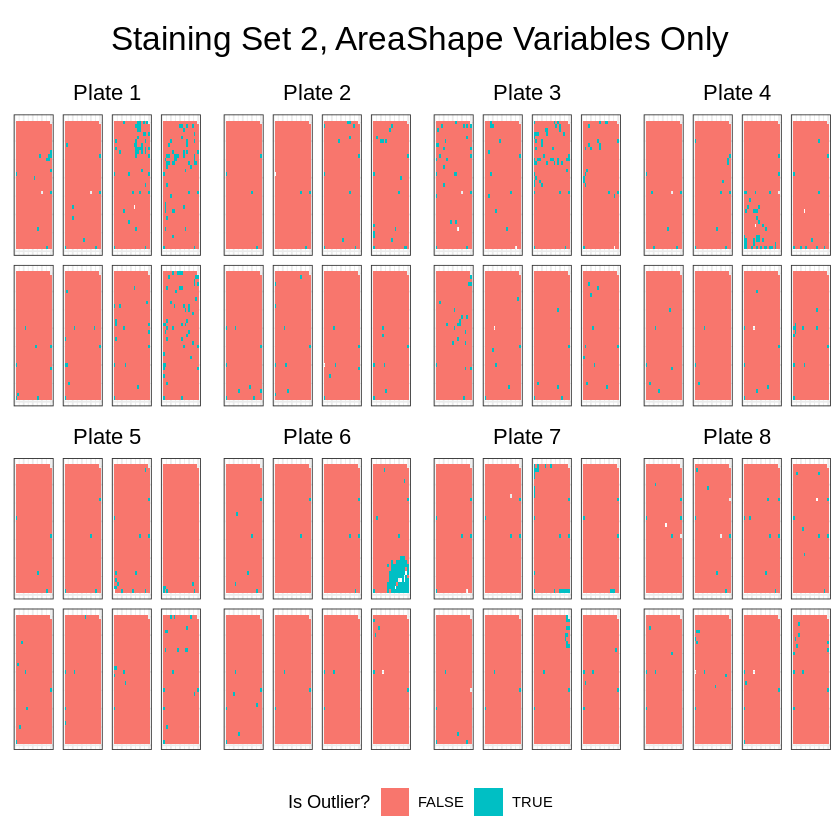

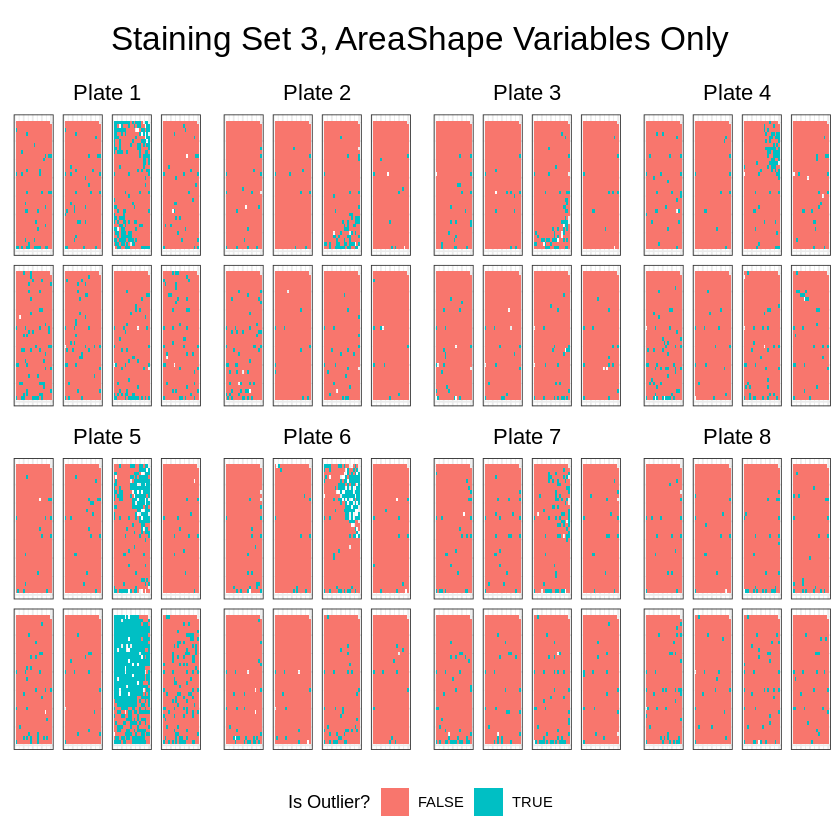

In [79]:
all_data2 %>%
  mutate(
    outlyingness_plots = map2(
      ss_num, data,
      make_outlyingness_plots,
      pattern = "AreaShape", invariance_type = "Shift", plot_type = "flag"
    )
  ) %>%
  select(!data) %>%
  with(walk(outlyingness_plots, print))